In [ ]:
def get_thresholds():
    data = []
    with open('./bot/config/thresholds.txt', 'r') as file:
        for line in file:
            line = line.strip()  # Удаляем пробелы и переносы строк
            if line:  # Игнорируем пустые строки
                # Преобразуем строку в кортеж с помощью literal_eval
                tuple_data = ast.literal_eval(line)
                data.append(tuple_data)
    return data

In [ ]:
from bot.data.http_api import ExchangeManager, BybitRestAPI, GateIORestAPI

import pandas as pd
import polars as pl
import numpy as np
# pd.options.display.float_format = '{:.2f}'.format
from datetime import datetime, timezone, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm

from bot.utils.files import get_saved_coins

In [ ]:
async def get_data(symbol, interval, n_iters, exchange):
    df = await exc_manager.get_candles(symbol=symbol, interval=interval, n_iters=n_iters)
    df = df[f'{exchange}_linear'].sort_index()
    return df.dropna()

In [ ]:
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))
coin_information = exc_manager.get_instrument_data()

In [ ]:
exchange = 'bybit'

token_list = ['AI16Z_USDT', 'APT_USDT', 'ARB_USDT', 'ARKM_USDT', 'ASTR_USDT',
              'BLUR_USDT',
              'CELO_USDT', 'CHZ_USDT', 'COTI_USDT', 'CRV_USDT', 'CVX_USDT',
              'DOT_USDT', 'DYM_USDT',
              'FIL_USDT', 'FLOW_USDT',
              'GALA_USDT', 'GMT_USDT', 'GRT_USDT', 'JASMY_USDT',
              'IMX_USDT', 'IOTA_USDT', 'KAS_USDT', 'KSM_USDT',
              'LDO_USDT',
              'MANA_USDT', 'MANTA_USDT', 'MORPHO_USDT', 'NEAR_USDT',
              'OGN_USDT', 'ONDO_USDT', 'OP_USDT', 'ORDI_USDT',
              'POL_USDT', 'RENDER_USDT', 'ROSE_USDT',
              'SAGA_USDT', 'SAND_USDT', 'SEI_USDT',  'STG_USDT', 'STRK_USDT',
              'STX_USDT', 'SUSHI_USDT',
              'TIA_USDT', 'VET_USDT',
              'XRP_USDT', 'YGG_USDT',
              'ZEN_USDT', 'ZK_USDT', 'ZRX_USDT']

syms = [col[:-5] for col in token_list]

In [ ]:
syms = ['XRP', ]

In [ ]:
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))

start_date = datetime.now().replace(microsecond=0) - timedelta(days=60)
end_date = None

for symbol in syms:
    fund_hist = await exc_manager.get_funding_history(symbol=f'{symbol}_USDT', start_date=start_date, limit=500)
    fund_hist = fund_hist[0]

    fund_sum = float(fund_hist['funding'].sum())
    fund_len = fund_hist['funding'].shape[0]

    hour_df = await get_data(symbol=f'{symbol}_USDT', interval='1h', n_iters=5, exchange=exchange)
    hour_df = hour_df.tail(4320) # Берём последние пол года
    hour_df.drop(['Exchange', 'Market_type'], axis=1, inplace=True)
    daily_df = await get_data(symbol=f'{symbol}_USDT', interval='1d', n_iters=1, exchange=exchange)
    daily_df = daily_df.tail(180) # Берём последние пол года

    hour_df['Max_range'] = hour_df['High'] - hour_df['Low']
    hour_df['Max_range_perc'] = (hour_df['High'] - hour_df['Low']) / hour_df['Low'] * 100
    hour_10 = hour_df[hour_df['Max_range_perc'] > 10].shape[0]
    hour_10_perc = 100 * hour_10 / hour_df.shape[0]
    hour_atr = hour_df['Max_range'].mean()
    hour_atr_perc = hour_df['Max_range_perc'].mean()
    hour_mtr_perc = hour_df['Max_range_perc'].max()

    daily_df['Max_range'] = daily_df['High'] - daily_df['Low']
    daily_df['Max_range_perc'] = (daily_df['High'] - daily_df['Low']) / daily_df['Low'] * 100
    days_10 = daily_df[daily_df['Max_range_perc'] > 10].shape[0]
    days_10_perc = 100 * days_10 / daily_df.shape[0]
    day_atr = daily_df['Max_range'].mean()
    day_atr_perc = daily_df['Max_range_perc'].mean()
    day_mtr_perc = daily_df['Max_range_perc'].max()

    print(f'========= {symbol} =========')
    print(f'Суммарный фандинг: {fund_sum * 100:.2f}%, расчётов по фандингу: {fund_len}')
    print(f'Фандинг. min: {fund_hist['funding'].min() * 100}%; max: {fund_hist['funding'].max() * 100}%')
    print()
    print(f'ATR за 1 день: {day_atr:.4f} ({day_atr_perc:.2f}%); за 1 час: {hour_atr:.4f} ({hour_atr_perc:.2f}%)')
    print(f'MaxTR за 1 день: {day_mtr_perc:.2f}%; за 1 час: {hour_mtr_perc:.2f}%')
    print(f'Колебания цены более 10%. Дни: {days_10} ({days_10_perc:.1f}%); Часы: {hour_10} ({hour_10_perc:.1f}%)')
    print()

In [ ]:
daily_df

#### Исследование монет

In [ ]:
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo

from tqdm.notebook import tqdm

from bot.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name
db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

from bot.utils.data import make_price_df_from_orderbooks_bulk, normalize
from bot.utils.pair_trading import make_df_from_orderbooks
from bot.data.http_api import ExchangeManager, BybitRestAPI


In [ ]:
# Если будет нужно отфильтровать датафрейм по времени

start_date = datetime(2025, 9, 16, 0, 0, tzinfo=ZoneInfo("Europe/Moscow"))
end_date = datetime(2025, 10, 4, 0, 0, tzinfo=ZoneInfo("Europe/Moscow"))
# tdf = spread_df.filter((pl.col('time') > start_date) & (pl.col('time') < end_date))

In [ ]:
# Задаём названия токенов для анализа
tokens = ['DOT', 'XRP', 'FIL', 'IOTA', 'XAI', 'C98', 'VET', 'NEAR', 'ONDO', 'IMX', 'SNX', 'SAND', 'ARKM', 'STG', 'CELO']

exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))
coin_information = exc_manager.get_instrument_data()

In [ ]:
for token in tokens:
    df_token = db_manager.get_orderbooks(symbol=token + '_USDT', interval='5m', start_date=start_date)

    daily_counts = df_token.group_by(pl.col("time").dt.date().alias("date")).agg(
        pl.len().alias("row_count")
    )

    plt.figure(figsize=(15, 3))
    plt.title(f'{token}')
    plt.plot(df_token['time'], df_token['price'])
    plt.grid()
    plt.show()

In [ ]:
# Создадим список из датафреймов для удобства пакетной обработки, а также получим кол-во знаков после запятой для округления
dfs = []
token_dp = {}

for token in tokens:
    df_token = db_manager.get_orderbooks(symbol=token + '_USDT', interval='5m', start_date=start_date, end_date=end_date)
    try:
        dp = coin_information['bybit_linear'][token + '_USDT']['qty_step']
    except IndexError:
        dp = 0

    token_dp[token] = dp
    dfs.append(df_token)

In [ ]:
# Создадим датафрейм, содержащий только цены, для анализа взаимосвязи монет
price_df = make_price_df_from_orderbooks_bulk(dfs=dfs, tokens=tokens, trunc='5m')
price_df.head(1)

In [ ]:
price_df.shape

In [ ]:
price_df.drop_nans().shape

In [ ]:
# Нормируем значения
normed_df = normalize(df=price_df, method='minimax', shift_to_zero=False)

In [ ]:
# Нарисуем график с нормализованными ценами
date_col = 'bucket' if 'bucket' in normed_df.columns else 'time'
price_cols = [c for c in normed_df.columns if c != date_col]

plt.figure(figsize=(14, 4))
for col in price_cols:
    plt.plot(normed_df[date_col].to_list(), normed_df[col].to_list(), label=col)

plt.xlabel("Время")
plt.ylabel("Нормализованная цена")
plt.title("Нормализованные цены монет")
plt.legend()
plt.grid(True)
plt.tight_layout()

In [ ]:
# Посчитаем евклидово расстояние между парами криптовалют
import itertools
import math

results = []

# Перебираем все уникальные пары колонок
for col1, col2 in itertools.combinations(price_cols, 2):
    diff_sq = (normed_df[col1] - normed_df[col2]) ** 2
    distance = math.sqrt(diff_sq.sum())
    results.append((col1, col2, distance))

In [ ]:
pl.DataFrame(results, schema=["coin1", "coin2", "dist"], orient="row").sort('dist'
            ).filter((pl.col('coin1') == 'ARKM') & (pl.col('coin2') == 'STG'))

In [ ]:
# "DOT"  "XRP"   2.17 - 15.73
# "FIL"  "XRP"   1.67 - 10.63
# "IOTA" "XAI"   1.55 - 9.29
# "IOTA" "SAND"  1.36 - 5.21
# "ONDO" "XRP"   1.28 - 12.52

# "ARKM" "STG"  -1.14 - 31.48
# "CELO" "STG"  -1.21 - 26.66
# "C98"  "VET"  -1.32 - 19.26
# "NEAR" "ONDO" -2.21 - 17.78
# "IMX"  "SNX"  -3.85 - 26.0


In [ ]:
df.tail(2)

In [ ]:
token_1 = 'CELO'
token_2 = 'ONDO'

df_1 = db_manager.get_orderbooks(symbol=token_1 + '_USDT', interval='1min')
df_2 = db_manager.get_orderbooks(symbol=token_2 + '_USDT', interval='1min')

In [ ]:
start_time = datetime(2025, 9, 6, 12, 0, tzinfo=ZoneInfo("Europe/Moscow"))
end_time = datetime(2025, 9, 6, 21, 0, tzinfo=ZoneInfo("Europe/Moscow"))

df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=start_time, end_time=end_time)
cols = [col for col in df.columns if 'ask' in col or 'bid' in col]
df = df.drop(cols)
# df = make_zscore_df(df, token_1, token_2, wind=480).drop_nulls()
# coef = df[0][token_1].item() / df[0][token_2].item()

In [ ]:
# Нарисуем график с нормализованными ценами
date_col = 'bucket' if 'bucket' in df.columns else 'time'
price_cols = [c for c in df.columns if c != date_col]

plt.figure(figsize=(14, 4))
plt.plot(df[date_col], df[token_1], label=token_1);
plt.plot(df[date_col], coef * df[token_2], label=token_2);
plt.xlabel("Время")
plt.ylabel("Цена")
plt.title(f"Приведённые к одному масштабу цены монет. Coef: {coef:.2f}")
plt.legend()
plt.grid(True)
plt.tight_layout()

In [ ]:
std = 2
upper_bound = df['mean'] + std * df['std']
lower_bound = df['mean'] - std * df['std']

plt.figure(figsize=(14, 2))
plt.plot(df[date_col], df['spread']);
plt.plot(df[date_col], upper_bound)
plt.plot(df[date_col], lower_bound)
plt.grid()

In [ ]:
train_time = datetime(2025, 8, 15, 3, 0, tzinfo=ZoneInfo("Europe/Moscow")) # За какое время рассчитываем mean & std для StandartScaler

spr_train = df.filter(pl.col(date_col) <= train_time)['spread'].to_numpy().reshape(-1, 1)
spr_test = df.filter(pl.col(date_col) > train_time)['spread'].to_numpy().reshape(-1, 1)

In [ ]:
scaler = StandardScaler()
scaler.fit(spr_train)
spr_normed = scaler.transform(spr_test).ravel()

In [ ]:
plt.figure(figsize=(14, 2))
plt.plot(spr_normed);
plt.title("Стандартизованный спред")
plt.grid()

#### Бектест одной торговой пары

In [ ]:
from bot.analysis.pair_trading import backtest
from bot.utils.pair_trading import make_df_from_orderbooks, make_trunc_df, create_zscore_df
from bot.analysis.strategy_analysis import analyze_strategy

from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo
import polars as pl
import numpy as np
import pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['timezone'] = 'Europe/Moscow'

from bot.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name
db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

In [4]:
token_1 = 'GRT'
token_2 = 'SEI'
spread_method = 'lr'
min_order = 40

valid_length = 0
train_length = 20

end_time = datetime.now().replace(tzinfo=ZoneInfo("Europe/Moscow"))
valid_time = (end_time - timedelta(days=valid_length)).replace(hour=0, minute=0, second=0, microsecond=0)
start_time = valid_time - timedelta(days=train_length)
start_ts = int(datetime.timestamp(valid_time))

n_tf = 2

if n_tf == 1:
    tf = '4h'
    winds = np.array([12, 18, 24, 30, 36])
elif n_tf == 2:
    tf_long = '4h'
    tf_short = '1h'
    winds_long = np.array([12, 18, 24, 30])
    winds_short = np.array([24, 48, 72, 96, 120])

In [ ]:
df_1 = db_manager.get_tick_ob(token=token_1 + '_USDT',
                                     start_time=start_time,
                                     end_time=end_time)
df_2 = db_manager.get_tick_ob(token=token_2 + '_USDT',
                                     start_time=start_time,
                                     end_time=end_time)
print(f'{token_1:>8} first date: {df_1['time'][0]}')
print(f'{token_2:>8} first date: {df_2['time'][0]}')

df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=start_time)
tick_df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=start_time)

if n_tf == 1:
    agg_df = make_trunc_df(df, timeframe=tf, token_1=token_1, token_2=token_2, method='triple')
    spread_df = create_zscore_df(token_1, token_2, tick_df, agg_df, tf, winds, min_order, start_ts, median_length=4)
    search_space = [(tf, int(w)) for w in winds]

elif n_tf == 2:
    agg_df_long = make_trunc_df(df, timeframe=tf_long, token_1=token_1, token_2=token_2, method='triple')
    agg_df_short = make_trunc_df(df, timeframe=tf_short, token_1=token_1, token_2=token_2, method='triple')

    spread_df_long = create_zscore_df(token_1, token_2, tick_df, agg_df_long, tf_long, winds_long, min_order, start_ts, median_length=4)
    spread_df_short = create_zscore_df(token_1, token_2, tick_df, agg_df_short, tf_short, winds_short, min_order, start_ts, median_length=4)
    cols_to_drop = [col for col in spread_df_short.columns if col in spread_df_long.columns]
    cols_to_drop.remove('time')

    spread_df = spread_df_long.join(spread_df_short.drop(cols_to_drop), on='time', coalesce=True)
    search_space = [(tf_long, int(w)) for w in winds_long] + [(tf_short, int(w)) for w in winds_short]

with open("./data/coin_information.pkl", "rb") as f:
    coin_information = pickle.load(f)

dp_1 = float(coin_information['bybit_linear'][token_1 + '_USDT']['qty_step'])
ps_1 = int(coin_information['bybit_linear'][token_1 + '_USDT']['price_scale'])
dp_2 = float(coin_information['bybit_linear'][token_2 + '_USDT']['qty_step'])
ps_2 = int(coin_information['bybit_linear'][token_2 + '_USDT']['price_scale'])

     GRT first date: 2025-10-18 00:00:00+03:00
     SEI first date: 2025-10-18 00:00:00+03:00


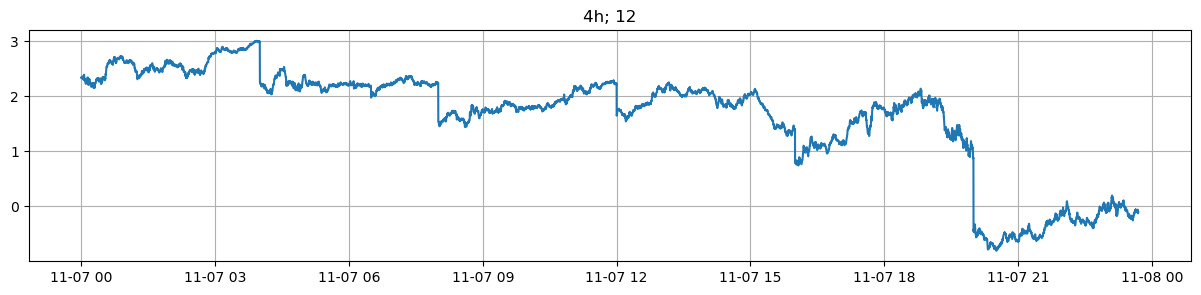

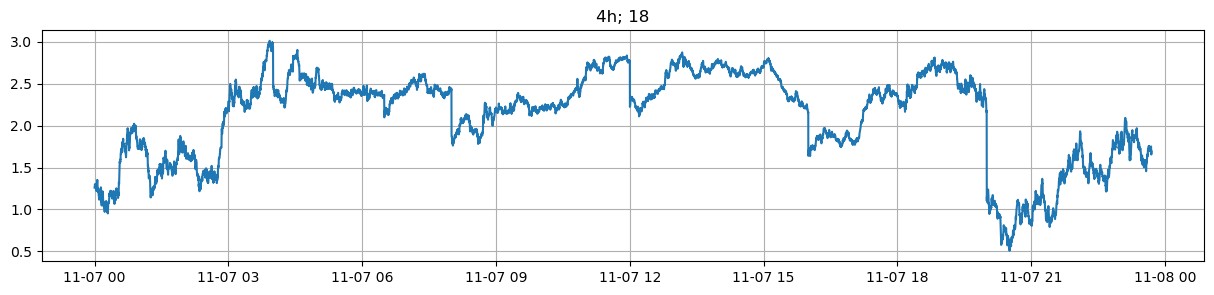

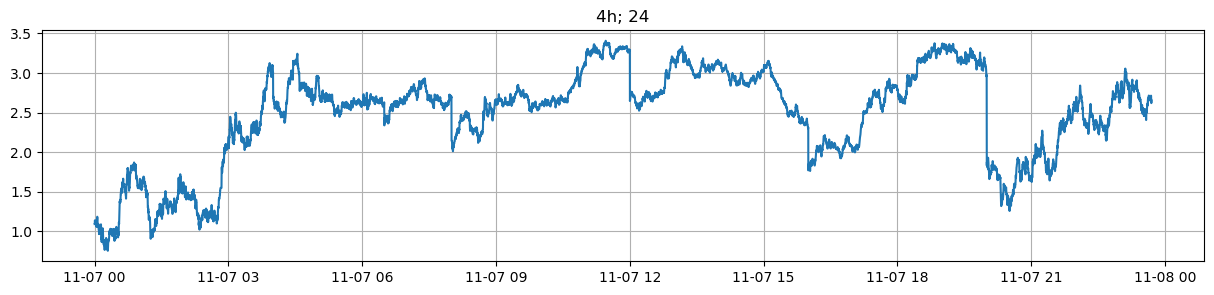

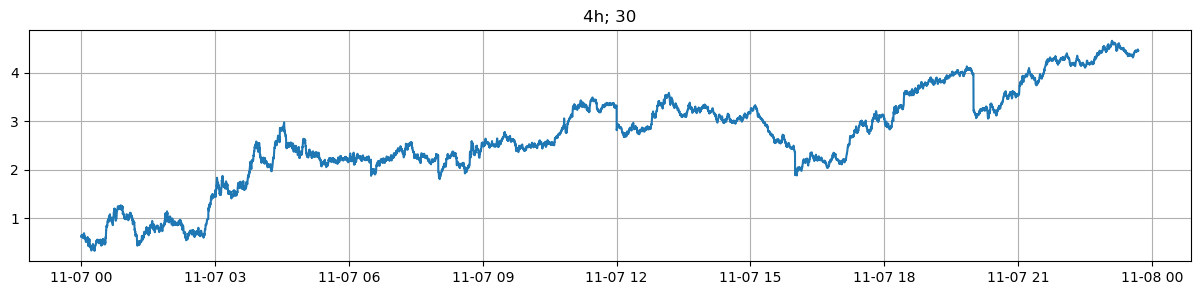

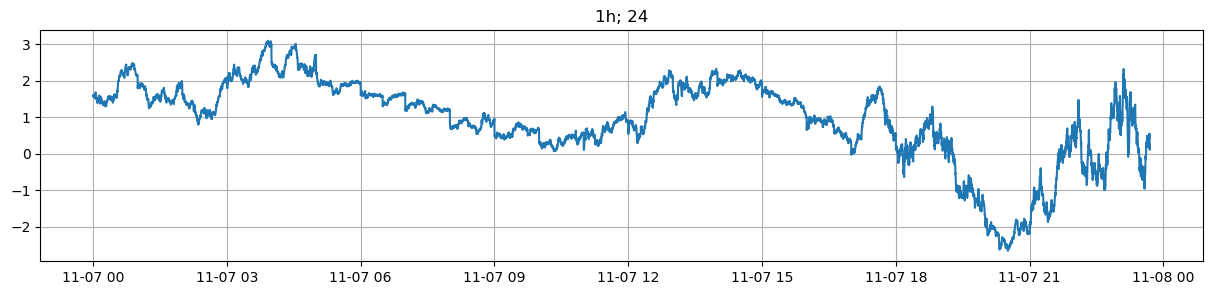

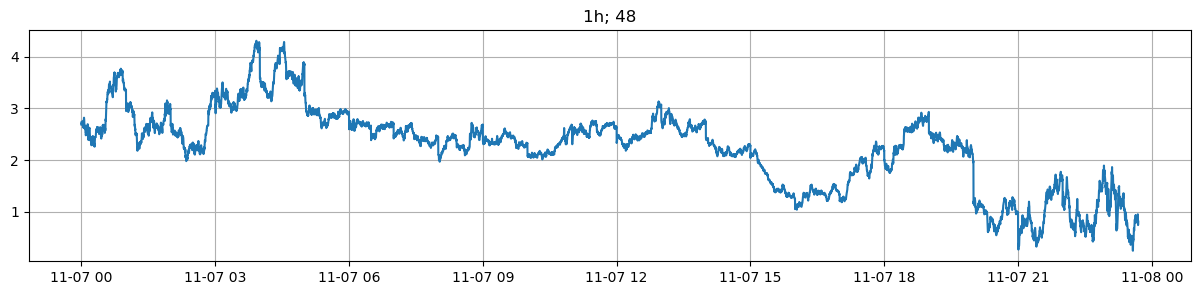

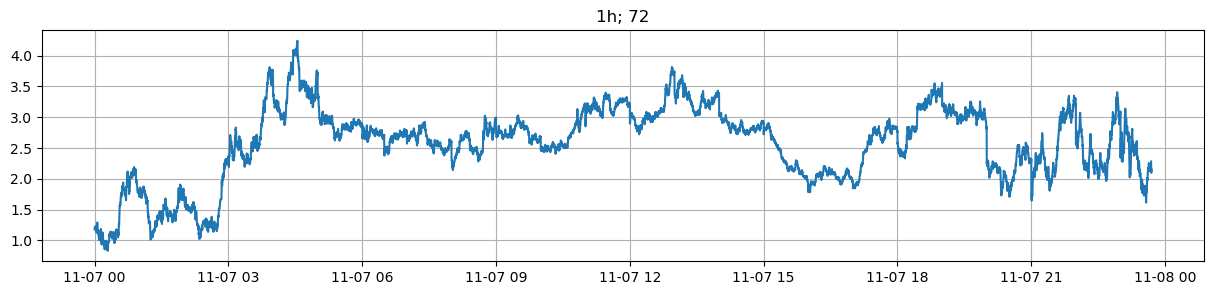

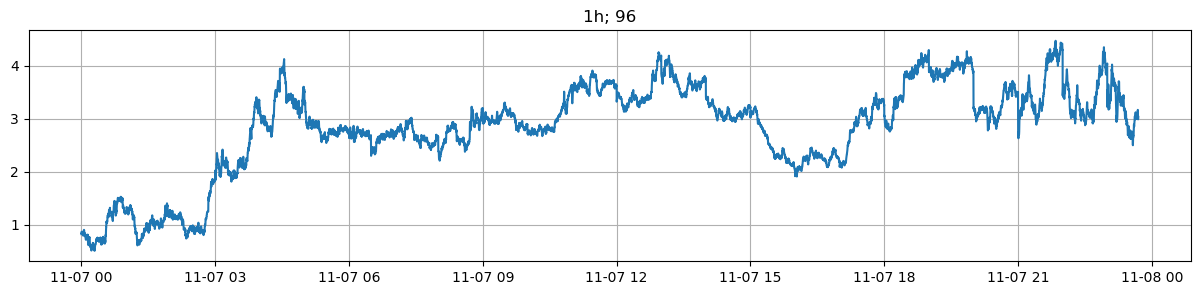

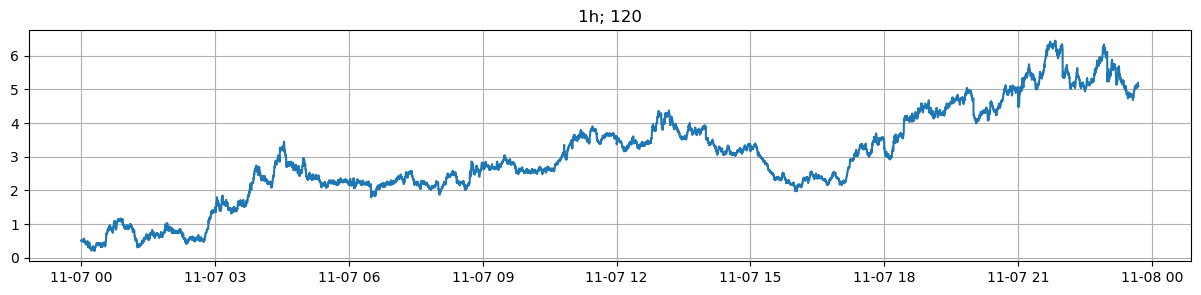

In [ ]:
for tf, wind in search_space:
    col_name = f'z_score_{wind}_{tf}'
    try:
        df = spread_df.select('time', 'ts', token_1, token_2, f'{token_1}_size', f'{token_2}_size',
             f'{token_1}_bid_price', f'{token_1}_ask_price', f'{token_1}_bid_size', f'{token_1}_ask_size',
             f'{token_2}_bid_price', f'{token_2}_ask_price', f'{token_2}_bid_size', f'{token_2}_ask_size',
             f'z_score_{wind}_{tf}').rename({f'z_score_{wind}_{tf}': 'z_score'})
    except pl.exceptions.ColumnNotFoundError:
        continue

    plt.figure(figsize=(15, 3))
    plt.title(f'{tf}; {wind}')
    plt.plot(df['time'], df['z_score'])
    plt.grid()
    plt.show()

In [ ]:
t = 720 * 24 * 15 # 72 hours

col_name = f'z_score_{wind}_{tf}'
df = spread_df.select('time', 'ts', token_1, token_2, f'{token_1}_size', f'{token_2}_size',
     f'{token_1}_bid_price', f'{token_1}_ask_price', f'{token_1}_bid_size', f'{token_1}_ask_size',
     f'{token_2}_bid_price', f'{token_2}_ask_price', f'{token_2}_bid_size', f'{token_2}_ask_size',
     f'z_score_{wind_long}_{tf_long}', f'z_score_{wind_short}_{tf_short}')
df = df.rename({f'z_score_{wind_long}_{tf_long}': 'z_score_long', f'z_score_{wind_short}_{tf_short}': 'z_score_short'})
df = df.with_columns(
    pl.when((pl.col('z_score_long') > 0) & (pl.col('z_score_short') > 0))
    .then(pl.min_horizontal('z_score_long', 'z_score_short'))
    .when((pl.col('z_score_long') < 0) & (pl.col('z_score_short') < 0))
    .then(pl.max_horizontal('z_score_long', 'z_score_short')).otherwise(0).alias('z_score')
)
# df = df.rename({'z_score_long': 'z_score'})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
# --- Графики цены ---
ax1.plot(df.select('time'), df.select(token_1), label=token_1, color='orange')
ax1.set_title(f'{token_1} - {token_2} ({tf_long=}, {wind_long=}; {tf_short=}, {wind_short=})')

ax1.set_ylabel('udst')
ax1.legend()
ax1.grid()

ax4 = ax1.twinx()
ax4.plot(df.select('time'), df.select(token_2), label=token_2, color='blue')

# --- График z_score ---
ax2.plot(df.select('time')[-t:], df.select('z_score')[-t:]);
ax2.set_title('z_score')
ax2.grid()

In [ ]:
start_time = "2025-09-23 18:00:33"
end_time = "2025-09-24 07:33:36"


In [ ]:
# df.filter(pl.col('time') <= tm).tail(3)

In [ ]:
params = {'thresh_in': 2.5, 'thresh_out': 0.5}

leverage = 2

trades_df = backtest(df, token_1, token_2, dp_1, dp_2, ps_1, ps_2,
            thresh_low_in=-params['thresh_in'], thresh_high_in=params['thresh_in'],
            thresh_low_out=-params['thresh_out'], thresh_high_out=params['thresh_out'],
            long_possible=True, short_possible=True, dist_in=0, dist_out=0,
            balance=100, order_size=50, fee_rate=0.00055, stop_loss_std=5.0, sl_method='leave',
            sl_seconds = 60,
            leverage=leverage,
            verbose=2)
end_date = df['time'][-1]
metrics = analyze_strategy(trades_df, start_date=valid_time, end_date=end_date, initial_balance=200.0)

In [ ]:
# -7.80

#### Бектест нескольких пар

In [ ]:
from bot.analysis.backtest.pair_trading import backtest
from bot.utils.pair_trading import make_df_from_orderbooks, make_trunc_df, create_zscore_df, select_cols_1tf
from bot.analysis.strategy_analysis import analyze_strategy

from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo
import polars as pl
from polars.exceptions import ColumnNotFoundError
import numpy as np
import pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['timezone'] = 'Europe/Moscow'

from bot.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name
db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

In [ ]:
method = 'lr'
start_bt_time = datetime(2025, 10, 21, 0, 0, tzinfo=ZoneInfo("Europe/Moscow"))
end_time = datetime(2025, 11, 1, 21, 50, tzinfo=ZoneInfo("Europe/Moscow"))

with open("./data/coin_information.pkl", "rb") as f:
    coin_information = pickle.load(f)

token_pairs = []
with open('./data/token_pairs.txt', 'r') as file:
    for line in file:
        a, b = line.strip().split()
        token_pairs.append((a, b))

In [ ]:
# Загружаем полный датасет
# df = pl.scan_parquet('./data/test_data_dist_2.parquet')

# Выбрасываем столбцы с информацией о спреде, он нам сейчас не нужен
# all_cols = df.collect_schema().names()
# cols_to_drop = [col for col in all_cols if '_spread_' in col]
# df = df.drop(cols_to_drop).collect()
# f'{df.estimated_size():_}'

In [ ]:
# Сначала отберём только те пары, которые с индиидуальным подбором параметров дают положительный результат
import ast

def get_thresholds():
    data = []
    with open('./data/ind_thresholds.txt', 'r') as file:
        for line in file:
            line = line.strip()  # Удаляем пробелы и переносы строк
            if line:  # Игнорируем пустые строки
                # Преобразуем строку в кортеж с помощью literal_eval
                tuple_data = ast.literal_eval(line)
                data.append(tuple_data)
    return data

thresholds = get_thresholds()

In [ ]:
leverage = 2
dist_in = 0
dist_out = 0

metrics_arr = []

for _, token_1, token_2, tf, wind, in_, out_ in tqdm(thresholds):
    try:
        metrics = dict()
        trades_arr = []

        dp_1 = float(coin_information['bybit_linear'][token_1 + '_USDT']['qty_step'])
        ps_1 = int(coin_information['bybit_linear'][token_1 + '_USDT']['price_scale'])
        dp_2 = float(coin_information['bybit_linear'][token_2 + '_USDT']['qty_step'])
        ps_2 = int(coin_information['bybit_linear'][token_2 + '_USDT']['price_scale'])

        filepath = f'./data/pair_backtest/{token_1}_{token_2}_lr_full.parquet'
        try:
            df = pl.read_parquet(filepath, low_memory=True, rechunk=True, use_pyarrow=True)
        except FileNotFoundError:
            print(token_1, token_2)
            continue

        cols = ['time', 'ts', token_1, f'{token_1}_size', f'{token_1}_bid_price', f'{token_1}_ask_price',
            f'{token_1}_bid_size', f'{token_1}_ask_size', token_2, f'{token_2}_size',
            f'{token_2}_bid_price', f'{token_2}_ask_price', f'{token_2}_bid_size', f'{token_2}_ask_size',
            f'z_score_{wind}_{tf}']

        tdf = df.select(cols).rename({f'z_score_{wind}_{tf}': 'z_score'}).drop_nulls()

        trades_df = backtest(tdf, token_1, token_2, dp_1, dp_2, ps_1, ps_2,
            thresh_low_in=-in_, thresh_low_out=-out_, thresh_high_in=in_, thresh_high_out=out_,
            long_possible=True, short_possible=True,
            balance=100, order_size=50, fee_rate=0.00055, stop_loss_std=5.0, sl_method='leave',
            sl_seconds = 60, leverage=leverage, dist_in=0, dist_out=0,
            verbose=0)

        if trades_df.height > 0:
            trades_arr.extend(trades_df.to_dicts())
            end_date = df['time'][-1]

        all_trades = pl.DataFrame(trades_arr)
        metrics = analyze_strategy(all_trades, start_date=start_bt_time, end_date=end_date, initial_balance=100.0)

        if metrics:
            metrics_arr.append({
                            'token_1': token_1, 'token_2': token_2, 'tf': tf, 'wind': wind,
                            'thresh_in': in_, 'thresh_out': out_, 'dist_in': dist_in, 'dist_out': dist_out,
                            'n_trades': metrics['n_trades'], 'duration_avg': metrics['duration_avg'],
                            'stop_losses': metrics['stop_losses'], 'liquidations': metrics['liquidations'],
                            'profit': metrics['profit'], 'profit_ratio': metrics['profit_ratio'],
                            'max_profit': metrics['max_profit'], 'max_drawdown': metrics['max_drawdown'],
                            'max_loss': metrics['max_loss'], 'avg_profit': metrics['avg_profit'],
                            'profit_std': metrics['profit_std']})
    except ColumnNotFoundError:
        print('err')
        continue

output = pl.DataFrame(metrics_arr)
output.select(
    'token_1', 'token_2', 'profit', 'profit_ratio', 'max_loss', 'max_drawdown', 'duration_avg', 'n_trades'
).write_parquet('./data/ind_params_result.parquet')

In [ ]:
output.sample(5)

In [ ]:
# Уберём из выборки все пары, у которых profit_ratio < 1.0 для индивидуально подобранных параметров

token_pairs = []

for pr_ratio, token_1, token_2, tf, wind, in_, out_ in thresholds:
    if pr_ratio > 1:
        token_pairs.append((token_1, token_2))

In [ ]:
len(token_pairs)

In [ ]:
leverage = 2

search_space = (
    ('4h', 12), ('4h', 14), ('4h', 16), ('4h', 18), ('4h', 24),
    ('1h', 18), ('1h', 24), ('1h', 36), ('1h', 48), ('1h', 64), ('1h', 72), ('1h', 96), ('1h', 120)
)

in_params = (2.5, 2.25, 2.0, 1.8, 1.6)
# out_params = (0.0, 0.25, 0.5)
out_params = (0.25, )

dist_in = 0
dist_out = 0

s_len= len(search_space) * len(in_params) * len(out_params) * len(token_pairs)

print('Whole search space size:', s_len)

In [ ]:
metrics_arr = []

with tqdm(total=s_len, desc="Обработка", unit="iter") as progress_bar:
    for token_1, token_2 in token_pairs:
        dp_1 = float(coin_information['bybit_linear'][token_1 + '_USDT']['qty_step'])
        ps_1 = int(coin_information['bybit_linear'][token_1 + '_USDT']['price_scale'])
        dp_2 = float(coin_information['bybit_linear'][token_2 + '_USDT']['qty_step'])
        ps_2 = int(coin_information['bybit_linear'][token_2 + '_USDT']['price_scale'])

        filepath = f'./data/pair_backtest/{token_1}_{token_2}_lr_full.parquet'
        try:
            df = pl.read_parquet(filepath, low_memory=True, rechunk=True, use_pyarrow=True)
        except FileNotFoundError:
            print(token_1, token_2)
            continue

        end_date = df['time'][-1]

        for tf, wind in search_space:
            for in_ in (in_params):
                for out_ in (out_params):
                    progress_bar.update(1)
                    metrics = dict()

                    cols = ['time', 'ts', token_1, f'{token_1}_size', f'{token_1}_bid_price', f'{token_1}_ask_price',
                            f'{token_1}_bid_size', f'{token_1}_ask_size', token_2, f'{token_2}_size',
                            f'{token_2}_bid_price', f'{token_2}_ask_price', f'{token_2}_bid_size', f'{token_2}_ask_size',
                            f'z_score_{wind}_{tf}']

                    tdf = df.select(cols).rename({f'z_score_{wind}_{tf}': 'z_score'}).drop_nulls()

                    trades_df = backtest(tdf, token_1, token_2, dp_1, dp_2, ps_1, ps_2,
                            thresh_low_in=-in_, thresh_low_out=-out_, thresh_high_in=in_, thresh_high_out=out_,
                            long_possible=True, short_possible=True,
                            balance=100, order_size=50, fee_rate=0.00055, stop_loss_std=5.0, sl_method='leave',
                            sl_seconds = 60, leverage=leverage, dist_in=0, dist_out=0,
                            verbose=0)

                    if trades_df.height > 0:
                        metrics = analyze_strategy(trades_df, start_date=start_bt_time, end_date=end_date, initial_balance=100.0)

                    if metrics:
                        metrics_arr.append({
                            'token_1': token_1, 'token_2': token_2, 'tf': tf, 'wind': wind,
                            'thresh_in': in_, 'thresh_out': out_, 'dist_in': dist_in, 'dist_out': dist_out,
                            'n_trades': metrics['n_trades'], 'duration_avg': metrics['duration_avg'],
                            'stop_losses': metrics['stop_losses'], 'liquidations': metrics['liquidations'],
                            'profit': metrics['profit'], 'profit_ratio': metrics['profit_ratio'],
                            'max_profit': metrics['max_profit'], 'max_drawdown': metrics['max_drawdown'],
                            'max_loss': metrics['max_loss'], 'avg_profit': metrics['avg_profit'],
                            'profit_std': metrics['profit_std']})


In [ ]:
output = pl.DataFrame(metrics_arr).sort(by='profit', descending=True)
output.tail(2)

In [ ]:
output.group_by('tf', 'wind', 'thresh_in', 'thresh_out').agg(
    pl.col('profit').mean().round(2).alias('avg_profit'),
    pl.col('profit_ratio').mean().round(2).alias('avg_pr_ratio'),
    pl.col('max_loss').min().round(2).alias('max_loss'),
    pl.col('max_drawdown').mean().round(2).alias('avg_drawdown'),
    pl.col('max_drawdown').min().round(2).alias('max_drawdown'),
    pl.col('n_trades').mean().cast(pl.Int64).alias('avg_trades'),
).sort('avg_pr_ratio', descending=True).head(10)

In [ ]:
res_df = output.group_by('token_1', 'token_2').agg(
            pl.col('profit').mean().round(2).alias('avg_profit'),
            pl.col('profit').std().round(2).alias('profit_std'),
            pl.col('max_loss').min().round(2).alias('max_loss'),
            pl.col('max_drawdown').mean().round(2).alias('avg_drawdown'),
            pl.col('max_drawdown').min().round(2).alias('max_drawdown'),
            pl.col('duration_avg').mean().alias('avg_duration'),
            pl.col('profit_ratio').mean().round(2).alias('avg_pr_ratio'),
            pl.col('n_trades').mean().cast(pl.Int64).alias('avg_trades'),
        ).sort('avg_pr_ratio', descending=True)
res_df

In [ ]:
# res_df.write_parquet('./data/common_params_result.parquet')

In [ ]:
# Возьмём только те пары, которые показали хороший результат, и для них подберём наилучшие параметры
token_pairs = []

for row in res_df.iter_rows(named=True):
    if row['avg_pr_ratio'] > 0.2:
        token_pairs.append((row['token_1'], row['token_2']))
len(token_pairs)

In [ ]:
# После чего повторим предыдущий шаг с подбором параметров торговли уже с условием выхода 0.25

In [ ]:
# Оставляем только лучшие параметры
leverage = 2
tf = '4h'
wind = 24
in_ = 1.6
out_ = 0.25
dist_in = 0
dist_out = 0

metrics_arr = []

for token_1, token_2 in tqdm(token_pairs):
    dp_1 = float(coin_information['bybit_linear'][token_1 + '_USDT']['qty_step'])
    ps_1 = int(coin_information['bybit_linear'][token_1 + '_USDT']['price_scale'])
    dp_2 = float(coin_information['bybit_linear'][token_2 + '_USDT']['qty_step'])
    ps_2 = int(coin_information['bybit_linear'][token_2 + '_USDT']['price_scale'])

    filepath = f'./data/pair_backtest/{token_1}_{token_2}_lr_full.parquet'
    try:
        df = pl.read_parquet(filepath, low_memory=True, rechunk=True, use_pyarrow=True)
    except FileNotFoundError:
        continue

    end_date = df['time'][-1]
    metrics = dict()

    cols = ['time', 'ts', token_1, f'{token_1}_size', f'{token_1}_bid_price', f'{token_1}_ask_price',
            f'{token_1}_bid_size', f'{token_1}_ask_size', token_2, f'{token_2}_size',
            f'{token_2}_bid_price', f'{token_2}_ask_price', f'{token_2}_bid_size', f'{token_2}_ask_size',
            f'z_score_{wind}_{tf}']

    tdf = df.select(cols).rename({f'z_score_{wind}_{tf}': 'z_score'}).drop_nulls()

    trades_df = backtest(tdf, token_1, token_2, dp_1, dp_2, ps_1, ps_2,
            thresh_low_in=-in_, thresh_low_out=-out_, thresh_high_in=in_, thresh_high_out=out_,
            long_possible=True, short_possible=True,
            balance=100, order_size=50, fee_rate=0.00055, stop_loss_std=5.0, sl_method='leave',
            sl_seconds = 60, leverage=leverage, dist_in=0, dist_out=0,
            verbose=0)

    if trades_df.height > 0:
        metrics = analyze_strategy(trades_df, start_date=start_bt_time, end_date=end_date, initial_balance=100.0)

    if metrics:
        metrics_arr.append({
            'token_1': token_1, 'token_2': token_2, 'tf': tf, 'wind': wind,
            'thresh_in': in_, 'thresh_out': out_, 'dist_in': dist_in, 'dist_out': dist_out,
            'n_trades': metrics['n_trades'], 'duration_avg': metrics['duration_avg'],
            'stop_losses': metrics['stop_losses'], 'liquidations': metrics['liquidations'],
            'profit': metrics['profit'], 'profit_ratio': metrics['profit_ratio'],
            'max_profit': metrics['max_profit'], 'max_drawdown': metrics['max_drawdown'],
            'max_loss': metrics['max_loss'], 'avg_profit': metrics['avg_profit'],
            'profit_std': metrics['profit_std']})

In [ ]:
output = pl.DataFrame(metrics_arr).sort(by='profit', descending=True)
output.tail(2)

In [ ]:
output = pl.DataFrame(metrics_arr)
output.select(
    'token_1', 'token_2', 'profit', 'profit_ratio', 'max_loss', 'max_drawdown', 'duration_avg', 'n_trades'
).write_parquet('./data/best_params_result.parquet')

#### Симуляция торговли

In [ ]:
from bot.analysis.backtest.pair_trading import backtest
from bot.utils.pair_trading import make_df_from_orderbooks, get_qty, run_single_tf_backtest
from bot.utils.pair_trading import run_double_tf_backtest, run_single_tf_backtest_reverse, select_cols_1tf, select_cols_2tf
from bot.analysis.strategy_analysis import analyze_strategy
from bot.utils.coins import get_step_info, get_price_scale

from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo
import polars as pl
import numpy as np
import pickle
import random
import json
import ast
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['timezone'] = 'Europe/Moscow'

from bot.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name
db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

In [ ]:
method = 'lr'
start_bt_time = datetime(2025, 9, 16, 0, tzinfo=ZoneInfo("Europe/Moscow"))
end_time = datetime(2025, 9, 26, 0, tzinfo=ZoneInfo("Europe/Moscow"))

with open("./data/coin_information.pkl", "rb") as f:
    coin_information = pickle.load(f)

token_pairs = []
with open('./bot/config/token_pairs_test.txt', 'r') as file:
    for line in file:
        a, b = line.strip().split()
        token_pairs.append((a, b))

In [ ]:
def check_pos(name):
    token_1, token_2, *_ = name.split('_')
    return any(a == token_1 and b == token_2 for a, b, _ in pairs)

In [ ]:
def get_thresholds():
    data = []
    with open('./bot/config/thresholds_test.txt', 'r') as file:
        for line in file:
            line = line.strip()  # Удаляем пробелы и переносы строк
            if line:  # Игнорируем пустые строки
                # Преобразуем строку в кортеж с помощью literal_eval
                tuple_data = ast.literal_eval(line)
                data.append(tuple_data)
    return data

In [ ]:
def create_single_tf_backtest_df(token_pairs, start_time, end_time, tf, wind, method):
    time_series = pl.datetime_range(start=start_time, end=end_time, interval="5s", eager=True)
    main_df = pl.DataFrame({'time': time_series})

    for token_1, token_2 in token_pairs:
        try:
            spread_df = pl.read_parquet(f'./data/pair_backtest/{token_1}_{token_2}_{method}_full.parquet',
                low_memory=True, use_pyarrow=True).filter(
                    (pl.col('time') >= start_time) & (pl.col('time') < end_time)
                ).select('time', token_1, f'{token_1}_size', f'{token_1}_bid_price', f'{token_1}_ask_price',
                    f'{token_1}_bid_size', f'{token_1}_ask_size', token_2, f'{token_2}_size',
                    f'{token_2}_bid_price', f'{token_2}_ask_price', f'{token_2}_bid_size', f'{token_2}_ask_size',
                    f'z_score_{wind}_{tf}'
                ).rename({f'z_score_{wind}_{tf}': f'{token_1}_{token_2}_z_score'})

            if token_1 not in main_df.columns:
                df = spread_df.select('time', token_1, f'{token_1}_size', f'{token_1}_bid_price', f'{token_1}_ask_price',
                    f'{token_1}_bid_size', f'{token_1}_ask_size')
                main_df = main_df.join(df, on='time', how='full', coalesce=True)
            if token_2 not in main_df.columns:
                df = spread_df.select('time', token_2, f'{token_2}_size', f'{token_2}_bid_price', f'{token_2}_ask_price',
                    f'{token_2}_bid_size', f'{token_2}_ask_size')
                main_df = main_df.join(df, on='time', how='full', coalesce=True)

            df = spread_df.select('time', f'{token_1}_{token_2}_z_score')
            main_df = main_df.join(df, on='time', how='full', coalesce=True)
        except FileNotFoundError:
            continue

    return main_df

In [ ]:
def create_double_tf_backtest_df(token_pairs, start_time, end_time, tf_1, wind_1, tf_2, wind_2):

    time_series = pl.datetime_range(start=start_time, end=end_time, interval="1s", eager=True)
    main_df = pl.DataFrame({'time': time_series})

    for token_1, token_2 in token_pairs:
        try:
            spread_df = pl.scan_parquet(f'./data/pair_backtest/{token_1}_{token_2}_{method}_full.parquet').filter(
                    (pl.col('time') >= start_time) & (pl.col('time') < end_time)
                ).select('time', token_1, f'{token_1}_size', f'{token_1}_bid_price', f'{token_1}_ask_price',
                    f'{token_1}_bid_size', f'{token_1}_ask_size', token_2, f'{token_2}_size',
                    f'{token_2}_bid_price', f'{token_2}_ask_price', f'{token_2}_bid_size', f'{token_2}_ask_size',
                    f'z_score_{wind_1}_{tf_1}', f'z_score_{wind_2}_{tf_2}'
                ).rename({f'z_score_{wind_1}_{tf_1}': f'{token_1}_{token_2}_z_score_1',
                          f'z_score_{wind_2}_{tf_2}': f'{token_1}_{token_2}_z_score_2'}).collect()

            if token_1 not in main_df.columns:
                df = spread_df.select('time', token_1, f'{token_1}_size', f'{token_1}_bid_price', f'{token_1}_ask_price',
                    f'{token_1}_bid_size', f'{token_1}_ask_size')
                main_df = main_df.join(df, on='time')
            if token_2 not in main_df.columns:
                df = spread_df.select('time', token_2, f'{token_2}_size', f'{token_2}_bid_price', f'{token_2}_ask_price',
                    f'{token_2}_bid_size', f'{token_2}_ask_size')
                main_df = main_df.join(df, on='time')

            df = spread_df.select('time', f'{token_1}_{token_2}_z_score_1', f'{token_1}_{token_2}_z_score_2')
            main_df = main_df.join(df, on='time')

        except FileNotFoundError:
            continue

    return main_df

In [ ]:
# Загружаем полный датасет
df = pl.scan_parquet('./data/test_data.parquet')

# Выбрасываем столбцы с информацией о спреде, он нам сейчас не нужен
all_cols = df.collect_schema().names()
cols_to_drop = [col for col in all_cols if '_spread_' in col]

df = df.drop(cols_to_drop).collect()
f'{df.estimated_size():_}'

#### Поиск наилучших параметров для прямого входа на 1 таймфрейме

In [ ]:
start_time = datetime(2025, 9, 16, 0, tzinfo=ZoneInfo("Europe/Moscow"))
end_time = datetime(2025, 9, 26, 0, tzinfo=ZoneInfo("Europe/Moscow"))

metrics_arr = []
in_params = (1.6, 1.8, 2.0, 2.25, 2.5)
out_params = (0.25, 0.5, 0.75, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5)
dist_in_params = (0.1, 0.2, 0.3, 0.4, 0.5)
dist_out_params = (0.1, 0.2, 0.3, 0.4, 0.5)

winds = [18, ]
leverage = 2
max_pairs = 5
min_order_size = 40
max_order_size = 50
fee_rate = 0.00055

ln = len(in_params) * len(out_params) * len(winds) * len(dist_out_params)
ln

In [ ]:
# Симуляция одного таймфрейма с прямым входом и выходом
tf = '4h'

with tqdm(total=ln, desc="Обработка", unit="iter") as progress_bar:
    for wind in winds:
        tdf = select_cols_1tf(df, token_pairs, tf, wind)

        for in_ in in_params:
            for out_ in out_params:
                if abs(out_) > abs(in_):
                    continue

                trades_df, metrics = run_single_tf_backtest(tdf, tf, wind, in_, out_, leverage, max_pairs, max_order_size,
                           fee_rate, start_time, end_time, coin_information)

                if trades_df.is_empty():
                    progress_bar.update(1)
                    continue

                metrics_arr.append({'tf': tf, 'wind': wind, 'thresh_in': in_, 'thresh_out': out_,
                    'n_trades': metrics['n_trades'], 'duration_min': metrics['duration_min'], 'duration_max': metrics['duration_max'],
                    'duration_avg': metrics['duration_avg'], 'stop_losses': metrics['stop_losses'], 'liquidations': metrics['liquidations'],
                    'profit': metrics['profit'], 'max_drawdown': metrics['max_drawdown'], 'max_profit': metrics['max_profit'],
                    'max_loss': metrics['max_loss'], 'avg_profit': metrics['avg_profit'], 'profit_std': metrics['profit_std'],
                    'profit_ratio': metrics['profit_ratio']})
                progress_bar.update(1)


In [ ]:
output = pl.DataFrame(metrics_arr).sort(by='profit_ratio', descending=True).drop('duration_max', 'stop_losses', 'liquidations')
output.head(2)

In [ ]:
for row in output[:5].iter_rows(named=True):
    print(f"{row['tf']:2}, {row['wind']:2}, {row['thresh_in']:>4}, {row['thresh_out']:>4}, {row['n_trades']:>3}, \
{row['profit']:>6}, {row['max_drawdown']:>6}, {row['max_profit']:>6}, {row['max_loss']:>6}, \
{row['avg_profit']:>6}, {row['profit_std']:>5}, {row['profit_ratio']:>5}")

In [ ]:
# Симуляция одного таймфрейма со входом и выходом, когда спред возвращается к пороговому значению
tf = '4h'

dist_in = 0
dist_out = 0

with tqdm(total=ln, desc="Обработка", unit="iter") as progress_bar:
    for wind in winds:
        tdf = select_cols_1tf(df, token_pairs, tf, wind)

        for in_ in in_params:
            for out_ in out_params:
                for dist_out in dist_out_params:
                    if abs(out_) > abs(in_):
                        continue

                    try:
                        trades_df, metrics = run_single_tf_backtest_reverse(tdf, tf, wind, in_, out_, dist_in, dist_out, max_pairs, leverage,
                                                          reverse_in=False, reverse_out=True)

                        metrics_arr.append({'tf': tf, 'wind': wind, 'thresh_in': in_, 'thresh_out': out_, 'dist_in': dist_in, 'dist_out': dist_out,
                            'n_trades': metrics['n_trades'], 'duration_min': metrics['duration_min'], 'duration_max': metrics['duration_max'],
                            'duration_avg': metrics['duration_avg'], 'stop_losses': metrics['stop_losses'], 'liquidations': metrics['liquidations'],
                            'profit': metrics['profit'], 'max_drawdown': metrics['max_drawdown'], 'max_profit': metrics['max_profit'],
                            'max_loss': metrics['max_loss'], 'avg_profit': metrics['avg_profit'], 'profit_std': metrics['profit_std'],
                            'profit_ratio': metrics['profit_ratio']})
                        progress_bar.update(1)
                    except Exception:
                        continue
                        progress_bar.update(1)

In [ ]:
output = pl.DataFrame(metrics_arr).sort(by='profit', descending=True).drop('duration_max', 'stop_losses', 'liquidations')
output

In [ ]:
for row in output[:10].iter_rows(named=True):
    print(f"{row['tf']:2}, {row['wind']:2}, {row['thresh_in']:>4}, {row['thresh_out']:>4}, {row['n_trades']:>3}, {row['dist_in']:>4}, {row['dist_out']:>4}, \
{row['duration_avg']}, {row['profit']:>6}, {row['max_drawdown']:>6}, {row['max_profit']:>6}, {row['max_loss']:>6}, \
{row['avg_profit']:>6}, {row['profit_std']:>5}, {row['profit_ratio']:>5}")

In [ ]:
token_params[:2]

In [ ]:
df.head(1)

In [ ]:
def run_single_tf_best_params_backtest(main_df, leverage, max_pairs, max_order_size,
                           fee_rate, start_time, end_time, coin_information):
    tokens_in_position = []
    pairs = []
    current_orders = {}
    trades = []

    params = get_thresholds()
    token_params = sorted(params, key=lambda x: x[0], reverse=True)

    for prof, token_1, token_2, tf, wind, in_, out_ in token_params:
        if token_1 not in df.columns or token_2 not in df.columns:
            token_params.remove((prof, token_1, token_2, tf, wind, in_, out_))

    for row in main_df.iter_rows(named=True):
        time = row['time']

        for _, token_1, token_2, tf, wind, in_, out_ in token_params:
            try:
                z_score = row[f'{token_1}_{token_2}_z_score_{wind}_{tf}']
                low_in = -in_
                low_out = -out_
                high_in = in_
                high_out = out_
            except KeyError:
                continue

            if z_score is None or row[token_1] is None or row[token_2] is None:
                continue

            # ----- Проверяем условия для входа в позицию -----
            if (len(pairs) < max_pairs and token_1 not in tokens_in_position and token_2 not in tokens_in_position):

                # --- Входим в лонг ---
                if z_score < low_in:
                    t1_price = row[f'{token_1}_ask_price']
                    t2_price = row[f'{token_2}_bid_price']
                    t1_vol = row[f'{token_1}_ask_size']
                    t2_vol = row[f'{token_2}_bid_size']
                    qty_1, qty_2 = get_qty(token_1, token_2, t1_price, t2_price, None, coin_information, 2 * max_order_size * leverage,
                              method='usdt_neutral')
                    place_order(tokens_in_position, pairs, current_orders, trades, time, token_1, token_2,
                                'open', 'long', qty_1, qty_2, t1_price, t2_price, t1_vol, t2_vol, None, z_score,
                                tf, wind, in_, out_, fee_rate, min_order_size, max_order_size, leverage, verbose=False)

                # --- Открываем шорт ---
                if z_score > high_in:
                    t1_price = row[f'{token_1}_bid_price']
                    t2_price = row[f'{token_2}_ask_price']
                    t1_vol = row[f'{token_1}_bid_size']
                    t2_vol = row[f'{token_2}_ask_size']
                    qty_1, qty_2 = get_qty(token_1, token_2, t1_price, t2_price, None, coin_information, 2 * max_order_size * leverage,
                              method='usdt_neutral')
                    place_order(tokens_in_position, pairs, current_orders, trades, time, token_1, token_2,
                                'open', 'short', qty_1, qty_2, t1_price, t2_price, t1_vol, t2_vol, None, z_score,
                                tf, wind, in_, out_, fee_rate, min_order_size, max_order_size, leverage, verbose=False)

            # ----- Проверяем условия для выхода из позиции -----
            # --- Закрываем лонг ---
            if z_score > high_out and (token_1, token_2, 'long') in pairs:
                t1_price = row[f'{token_1}_bid_price']
                t2_price = row[f'{token_2}_ask_price']
                t1_vol = row[f'{token_1}_bid_size']
                t2_vol = row[f'{token_2}_ask_size']
                qty_1 = current_orders[(token_1, token_2)]['qty_1']
                qty_2 = current_orders[(token_1, token_2)]['qty_2']
                place_order(tokens_in_position, pairs, current_orders, trades, time, token_1, token_2,
                            'close', 'long', qty_1, qty_2, t1_price, t2_price, t1_vol, t2_vol, None, z_score,
                                tf, wind, in_, out_, fee_rate, min_order_size, max_order_size, leverage, reason=1, verbose=False)

            # --- Закрываем шорт ---
            if z_score < low_out and (token_1, token_2, 'short') in pairs:
                t1_price = row[f'{token_1}_ask_price']
                t2_price = row[f'{token_2}_bid_price']
                t1_vol = row[f'{token_1}_ask_size']
                t2_vol = row[f'{token_2}_bid_size']
                qty_1 = current_orders[(token_1, token_2)]['qty_1']
                qty_2 = current_orders[(token_1, token_2)]['qty_2']
                place_order(tokens_in_position, pairs, current_orders, trades, time, token_1, token_2,
                            'close', 'short', qty_1, qty_2, t1_price, t2_price, t1_vol, t2_vol, None, z_score,
                                tf, wind, in_, out_, fee_rate, min_order_size, max_order_size, leverage, reason=1, verbose=False)

            # --- Проверка стоп-лосса ---
            if (token_1, token_2, 'long') in pairs:
                op_1 = current_orders[(token_1, token_2)]['t1_price']
                op_2 = current_orders[(token_1, token_2)]['t2_price']
                t1_price = row[f'{token_1}_bid_price']
                t2_price = row[f'{token_2}_ask_price']

                sl_price_1 = op_1 - 0.85 * op_1 / leverage
                sl_price_2 = op_2 + 0.85 * op_2 / leverage

                if t1_price < sl_price_1 or t2_price > sl_price_2:
                    qty_1 = current_orders[(token_1, token_2)]['qty_1']
                    qty_2 = current_orders[(token_1, token_2)]['qty_2']
                    t1_vol = row[f'{token_1}_bid_size']
                    t2_vol = row[f'{token_2}_ask_size']

                    place_order(tokens_in_position, pairs, current_orders, trades, time, token_1, token_2,
                                'close', 'long', qty_1, qty_2, t1_price, t2_price, t1_vol, t2_vol, None, z_score,
                                tf, wind, in_, out_, fee_rate, min_order_size, max_order_size, leverage, reason=2, verbose=False)

            if (token_1, token_2, 'short') in pairs:
                op_1 = current_orders[(token_1, token_2)]['t1_price']
                op_2 = current_orders[(token_1, token_2)]['t2_price']
                t1_price = row[f'{token_1}_ask_price']
                t2_price = row[f'{token_2}_bid_price']

                sl_price_1 = op_1 + 0.85 * op_1 / leverage
                sl_price_2 = op_2 - 0.85 * op_2 / leverage

                if t1_price > sl_price_1 or t2_price < sl_price_2:
                    qty_1 = current_orders[(token_1, token_2)]['qty_1']
                    qty_2 = current_orders[(token_1, token_2)]['qty_2']
                    t1_vol = row[f'{token_1}_ask_size']
                    t2_vol = row[f'{token_2}_bid_size']

                    place_order(tokens_in_position, pairs, current_orders, trades, time, token_1, token_2,
                                'close', 'short', qty_1, qty_2, t1_price, t2_price, t1_vol, t2_vol, None, z_score,
                                tf, wind, in_, out_, fee_rate, min_order_size, max_order_size, leverage, reason=2, verbose=False)

    trades_df = pl.DataFrame(trades)
    if trades_df.is_empty():
        return pl.DataFrame(), dict()

    try:
        trades_df = trades_df.with_columns(
            (pl.col('open_time').dt.timestamp() // 1_000_000).alias('open_ts'),
            (pl.col('close_time').dt.timestamp() // 1_000_000).alias('close_ts'),
            (pl.col('close_time') - pl.col('open_time')).alias('duration'),
        )

        metrics = analyze_strategy(trades_df, start_date=start_time, end_date=end_time, initial_balance=200.0)
        return trades_df, metrics
    except pl.ColumnNotFoundError:
        return None

In [ ]:
trades_df, metrics = run_single_tf_best_params_backtest(df, leverage, max_pairs, max_order_size,
                           fee_rate, start_time, end_time, coin_information)

In [ ]:
trades_df

In [ ]:
metrics

In [ ]:
# ------- Top 5 profit (1 timeframe, direct) -------
#  tf  w   in    out  n_tr  avg_dur   profit   drdwn  mx_pr  mx_ls  avg_pr  std   pr_rat
# 1h, 48,  2.0, 0.25, 167, 12:22:55,  55.42, -28.27,  11.92,  -7.83,   0.33,  2.28,  2.77
# 1h, 64, 2.25, 0.25, 112, 15:34:33,  43.87, -26.72,  14.72, -10.92,   0.39,  2.92, 2.258
# 1h, 72,  2.0,  1.5,  61, 1d  9:57,  41.86, -18.62,   6.99,  -7.03,   0.69,  2.71, 2.775
# 1h, 24,  2.0,  1.5, 187, 13:54:57,  36.82, -40.85,   13.7, -11.04,    0.2,  2.59, 1.377
# 1h, 96,  1.4, 1.25,  57, 1d 18:03,  36.42, -21.08,  11.37, -10.76,   0.64,  3.85, 2.176

# 4h, 18,  2.0,  1.5,  54, 1d 13:01,  66.41,  -6.72,    8.85,  -6.31,   1.23,  2.76, 7.529
# 4h, 18,  1.8,  1.5,  57, 1d 15:36,  62.06,  -17.84,  23.05, -10.05,   1.09,  4.19, 4.114
# 4h, 24,  1.8,  1.5,  41, 2d 1:43,   47.7,   -17.59,   13.2,  -6.96,   1.16,  3.98, 3.202
# 4h, 18,  1.6,  1.5,  59, 1d 20:34,  47.22,  -29.56,  22.27,  -9.84,    0.8,  4.47, 2.192
# 4h, 14,  1.4, 1.25, 113, 1d  1:07,  40.86,  -41.67,  12.49, -11.89,   0.36,  3.15, 1.488

# 4h, 18,  1.8,  1.5,  58,  0,  0.1, 104.22,  -8.03,  22.74,  -6.47,    1.8,  3.86, 10.732
# 4h, 18,  1.8, 1.25,  57,  0,  0.3, 103.03,   -7.5,  19.17,  -3.72,   1.81,  3.68, 10.968
# 4h, 18,  1.8, 1.25,  71,  0,  0.2,   86.0, -14.73,  19.75,  -8.63,   1.21,  3.76, 6.469
# 4h, 18,  1.8, 1.25,  53,  0,  0.4,  70.38, -16.87,  19.57, -15.04,   1.33,  4.67, 4.791
# 4h, 18,  1.8,  1.5,  51,  0,  0.2,  68.49, -14.39,  22.08,  -6.56,   1.34,   4.2, 5.182

# 4h, 18,  1.6, 1.25,  70,  0.5,  0,   60.7, -15.67,  21.38, -12.36,   0.87,  4.14, 4.368
# 4h, 18,  1.6,  1.5,  59,  0.5,  0,  60.34, -14.93,  22.29,  -9.19,   1.02,  4.18, 4.467
# 4h, 18,  1.6,  1.5,  60,  0.5,  0,  49.58, -26.42,  22.29, -18.09,   0.83,  4.74, 2.487
# 4h, 24,  1.6, 1.25,  50,  0.5,  0,  41.85, -20.38,   10.3,  -6.99,   0.84,  3.28, 2.586
# 4h, 18,  1.6, 1.25,  68,  0.5,  0,  37.85, -13.37,  21.38, -13.37,   0.56,  3.94, 3.003

# ------- Top 5 profit ratio (1 timeframe, direct) -------
#  tf  w   in    out  n_tr  avg_dur   profit   drdwn  mx_pr   mx_ls   avg_pr  std   pr_rat
# 1h, 72,  2.0,  1.5,  61, 1d, 9:57,  41.86, -18.62,   6.99,  -7.03,   0.69,  2.71, 2.775
# 1h, 48,  2.0, 0.25, 167, 12:22:55,  55.42, -28.27,  11.92,  -7.83,   0.33,  2.28,  2.77
# 1h, 48,  2.0, 1.25, 108, 22:27:26,  32.96, -16.37,   8.56, -10.09,   0.31,  2.58, 2.377
# 1h, 64, 2.25, 0.25, 112, 15:34:33,  43.87, -26.72,  14.72, -10.92,   0.39,  2.92, 2.258
# 1h, 96,  1.4, 1.25,  57, 1d 18:03,  36.42, -21.08,  11.37, -10.76,   0.64,  3.85, 2.176

# 4h, 18,  2.0,  1.5,  54, 1d 13:01,  66.41,  -6.72,   8.85,  -6.31,   1.23,  2.76, 7.529
# 4h, 18,  1.8,  1.5,  57, 1d 15:36,  62.06, -17.84,  23.05, -10.05,   1.09,  4.19, 4.114
# 4h, 18,  2.0, 1.25,  61, 1d, 9:37,  40.44, -11.82,   9.34, -11.04,   0.66,  3.24, 3.482
# 4h, 24,  1.8,  1.5,  41, 2d, 1:43,   47.7, -17.59,   13.2,  -6.96,   1.16,  3.98, 3.202
# 4h, 18,  1.6, 1.25,  64, 1d 12:23,  38.54, -15.38,  21.41, -13.81,    0.6,  4.06, 2.809

# 4h, 18,  1.8, 1.25,  57,  0,  0.3, 102.86,   -7.5,  19.17,  -3.72,    1.8,  3.68, 10.949
# 4h, 18,  1.8,  1.5,  58,  0,  0.1,  104.1,  -8.09,  22.74,  -6.47,   1.79,  3.86, 10.684
# 4h, 18,  1.8, 1.25,  71,  0,  0.2,   86.0, -14.73,  19.75,  -8.63,   1.21,  3.76, 6.469
# 4h, 18,  1.8,  1.5,  37,  0,  0.3,  65.26, -12.17,  21.48, -10.44,   1.76,  5.51, 5.303
# 4h, 18,  1.8,  1.5,  51,  0,  0.2,  68.38, -14.39,  22.08,  -6.56,   1.34,   4.2, 5.173

# 4h, 18,  1.6,  1.5,  59, 0.5,   0,  60.34, -14.93,  22.29,  -9.19,   1.02,  4.18, 4.467
# 4h, 18,  1.6, 1.25,  70, 0.5,   0,   60.7, -15.67,  21.38, -12.36,   0.87,  4.14, 4.368
# 4h, 18,  1.6, 1.25,  68, 0.5,   0,  37.85, -13.37,  21.38, -13.37,   0.56,  3.94, 3.003
# 4h, 24,  1.6, 1.25,  50, 0.5,   0,  41.85, -20.38,   10.3,  -6.99,   0.84,  3.28, 2.586
# 4h, 18,  1.6,  1.5,  60, 0.5,   0,  49.58, -26.42,  22.29, -18.09,   0.83,  4.74, 2.487

#### Поиск наилучших параметров входа random search

In [ ]:
method = 'lr'
start_time = datetime(2025, 9, 16, 0, tzinfo=ZoneInfo("Europe/Moscow"))
end_time = datetime(2025, 9, 26, 0, tzinfo=ZoneInfo("Europe/Moscow"))
min_order_size = 40
max_order_size = 50
max_pairs = 5
leverage = 2
fee_rate = 0.00055

tfs = ('4h', '1h', '5m')
winds = {'4h': [10, 14, 18, 24],
         '1h': [36, 48, 60, 72, 96],
         '5m': [60, 90, 120, 180, 240, 300]}

n_tf_params = (1, 1, 2)
in_params = (1.75, 2.0, 2.25, 2.5)
out_params = (0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25)
dist_in_params = (0.1, 0.3, 0.5, 0.75)
dist_out_params = (0.1, 0.3, 0.5, 0.75)

metrics_arr = []

In [ ]:
n_iter = 5_000

with tqdm(total=n_iter, desc="Обработка", unit="iter") as progress_bar:
    for _ in range(n_iter):
        try:
            n_tf = random.choice(n_tf_params)
            trades_df, metrics = None, None

            if n_tf == 1:
                mode = random.choice(['1_tf_direct', '1_tf_rev_in', '1_tf_rev_out', '1_tf_rev_both'])
                tf_1 = random.choice(tfs[:2]) # На одиночном таймфрейме игнорируем '5m'
                wind_1 = random.choice(winds[tf_1])
                tf_2, wind_2 = 0, 0
                in_1 = random.choice(in_params)
                out_1 = random.choice(out_params)
                in_2, out_2 = 0, 0

                tdf = select_cols_1tf(df, token_pairs, tf_1, wind_1)

                if mode == '1_tf_direct':
                    dist_in, dist_out = 0, 0
                    trades_df, metrics = run_single_tf_backtest(tdf, tf_1, wind_1, in_1, out_1, leverage, max_pairs, max_order_size,
                           fee_rate, start_time, end_time, coin_information)
                elif mode == '1_tf_rev_in':
                    dist_in = random.choice(dist_in_params)
                    dist_out = 0
                    trades_df, metrics = run_single_tf_backtest_reverse(tdf, tf_1, wind_1, in_1, out_1, dist_in, dist_out, max_pairs, leverage,
                                   max_order_size, fee_rate, start_time, end_time, coin_information,
                                   reverse_in=True, reverse_out=False)
                elif mode == '1_tf_rev_out':
                    dist_in = 0
                    dist_out = random.choice(dist_out_params)
                    trades_df, metrics = run_single_tf_backtest_reverse(tdf, tf_1, wind_1, in_1, out_1, dist_in, dist_out, max_pairs, leverage,
                                   max_order_size, fee_rate, start_time, end_time, coin_information,
                                   reverse_in=False, reverse_out=True)
                elif mode == '1_tf_rev_both':
                    dist_in = random.choice(dist_in_params)
                    dist_out = random.choice(dist_out_params)
                    trades_df, metrics = run_single_tf_backtest_reverse(tdf, tf_1, wind_1, in_1, out_1, dist_in, dist_out, max_pairs, leverage,
                                   max_order_size, fee_rate, start_time, end_time, coin_information,
                                   reverse_in=True, reverse_out=True)

            elif n_tf == 2:
                mode = '2_tf_direct'
                tf_1, tf_2 = random.choices(tfs, k=2)
                wind_1 = random.choice(winds[tf_1])
                wind_2 = random.choice(winds[tf_2])
                dist_in, dist_out = 0, 0
                in_1 = random.choice(in_params)
                out_1 = random.choice(out_params)
                in_2 = random.choice(in_params)
                out_2 = random.choice(out_params)

                if tf_1 == tf_2 and wind_1 == wind_2:
                    continue
                if tf_1 == '5m' and tf_2 == '5m':
                    continue

                tdf = select_cols_2tf(df, token_pairs, tf_1=tf_1, wind_1=wind_1, tf_2=tf_2, wind_2=wind_2)
                trades_df, metrics = run_double_tf_backtest(tdf, tf_1, wind_1,
                                                tf_2, wind_2, in_1, out_1, in_2, out_2, leverage,
                                                max_pairs, max_order_size, fee_rate, start_time, end_time,
                                                coin_information)
            else:
                print('unknown mode!')
                continue

            if not metrics:
                continue

            log = {'n_tf': n_tf, 'tf_1': tf_1, 'tf_2': tf_2, 'wind_1': wind_1, 'wind_2': wind_2,
                    'in_1': in_1, 'in_2': in_2, 'out_1': out_1, 'out_2': out_2,
                    'dist_in': dist_in, 'dist_out': dist_out,
                    'n_trades': metrics['n_trades'],
                    'duration_min': metrics['duration_min'].total_seconds(), 'duration_max': metrics['duration_max'].total_seconds(),
                    'duration_avg': metrics['duration_avg'].total_seconds(), 'stop_losses': metrics['stop_losses'],
                    'liquidations': metrics['liquidations'],
                    'profit': metrics['profit'], 'max_drawdown': metrics['max_drawdown'], 'max_profit': metrics['max_profit'],
                    'max_loss': metrics['max_loss'], 'avg_profit': metrics['avg_profit'], 'profit_std': metrics['profit_std'],
                    'profit_ratio': metrics['profit_ratio']}
            json_log = json.dumps(log, default=float, ensure_ascii=False)
            with open('./logs/backtest_res.jsonl', 'a', encoding='utf-8') as f:
                f.write(json_log + '\n')

            # with open('./logs/trades_bt.jsonl', 'a', encoding='utf-8') as f:
            #     for trade in trades_df.to_dicts():
            #         trade.pop('open_time')
            #         trade.pop('close_time')
            #         trade.pop('duration')

            #         trade_log = json.dumps(trade, default=float, ensure_ascii=False)
            #         f.write(trade_log + '\n')

            if n_tf == 1 and mode[5:] == 'direct':
                                print(f'n_tf: {n_tf} ({mode[5:]:>8}); tf: {tf_1}; wind: {wind_1:>3}; in: {in_1:>4}; \
out: {out_1:>4}; profit: {metrics['profit']:.1f}')

            elif n_tf == 1 and mode[5:] == 'rev_in':
                print(f'n_tf: {n_tf} ({mode[5:]:>8}); tf: {tf_1}; wind: {wind_1:>3}; in: {in_1:>4}; \
out: {out_1:>4}; dist_in: {dist_in:>4}, profit: {metrics['profit']:.1f}')

            elif n_tf == 1 and mode[5:] == 'rev_out':
                print(f'n_tf: {n_tf} ({mode[5:]:>8}); tf: {tf_1}; wind: {wind_1:>3}; in: {in_1:>4}; \
out: {out_1:>4}; dist_out: {dist_out:>4}, profit: {metrics['profit']:.1f}')

            elif n_tf == 1 and mode[5:] == 'rev_out':
                print(f'n_tf: {n_tf} ({mode[5:]:>8}); tf: {tf_1}; wind: {wind_1:>3}; in: {in_1:>4}; \
out: {out_1:>4}; dist_in: {dist_in:>4}, dist_out: {dist_out:>4}, profit: {metrics['profit']:.1f}')

            elif n_tf == 2:
                print(f'n_tf: {n_tf} ({mode[5:]:>8}); tf_1: {tf_1}; wind_1: {wind_1:>3}; tf_2: {tf_2}; \
wind_2: {wind_2:>3}; in_1: {in_1:>4}; out_1: {out_1:>4}; in_2: {in_2:>4}; out_2: {out_2:>4}; profit: {metrics['profit']:.1f}')

            metrics_arr.append(log)
            progress_bar.update(1)
        except Exception as err:
            # print(err)
            # print(f'{mode=}; {tf_1=}; {wind_1=}; {tf_2=}; {wind_2=}; {in_1=}; {out_1=}; {in_2=}; {out_2=}; {dist_in=}, {dist_out=}')
            continue

In [ ]:
output = pl.DataFrame(metrics_arr).sort(by='profit_ratio', descending=True).drop('duration_min', 'duration_avg',
                            'duration_max', 'stop_losses', 'liquidations')
output

In [ ]:
for row in output[:5].iter_rows(named=True):
    print(row['tf'], row['wind'], row['thresh_in'], row['thresh_out'], row['n_trades'], row['duration_avg'], row['profit'],
         row['max_drawdown'], row['max_profit'], row['max_loss'], row['avg_profit'], row['profit_std'], row['profit_ratio'])

In [ ]:
mode, n_tf, tf_1, tf_2, wind_1, wind_2, dist_in, dist_out, in_1, out_1, in_2, out_2

#### EDA

In [ ]:
from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo
import polars as pl
import numpy as np
import pickle
import random
import json
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['timezone'] = 'Europe/Moscow'

In [ ]:
trades = pl.read_ndjson('./logs/trades_bt.jsonl')
trades = trades.unique()
# trades = trades.filter(pl.col('open_z_score') > 0)
# trades = trades.filter((pl.col('open_z_score') > 1.0) & (pl.col('open_z_score') < 5.0))
# start_times = trades['open_ts'].unique().to_list()

# trades = trades.with_columns(
#     (pl.col("total_profit") > 0).alias("profit_cat")
# )

In [ ]:
trades.height

In [ ]:
trades['open_z_score'].min(), trades['open_z_score'].max()

In [ ]:
trades['total_profit'].mean(), trades['total_profit'].median(), trades['total_profit'].min(), trades['total_profit'].max()

In [ ]:
sl_trades = trades.filter(pl.col('reason') != 1).group_by('token_1', 'token_2').agg(pl.col('total_profit').len().alias('n_trades'))

pairs_to_remove = []
for row in sl_trades.iter_rows(named=True):
    pairs_to_remove.append((row['token_1'], row['token_2']))

In [ ]:
pairs_to_remove

In [ ]:
profitable_trades = trades.group_by('token_1', 'token_2').agg(
    pl.col('total_profit').mean().alias('avg_profit'),
    pl.col('total_profit').min().alias('min_profit'),
    pl.col('total_profit').max().alias('max_profit'),
    pl.col('total_profit').len().alias('n_trades'),
    pl.col('reason').mean().alias('mean_reason')
).sort(by='avg_profit').filter(pl.col('avg_profit') > 0.5)

In [ ]:
profitable_trades

In [ ]:
t1_agg_trades = trades.group_by('token_1').agg(
    pl.col('total_profit').sum().alias('profit'),
    pl.col('total_profit').len().alias('n_trades'),
).rename({'token_1': 'token', 'profit': 'profit_1', 'n_trades': 'n_trades_1'})

t2_agg_trades = trades.group_by('token_2').agg(
    pl.col('total_profit').sum().alias('profit'),
    pl.col('total_profit').len().alias('n_trades'),
).rename({'token_2': 'token', 'profit': 'profit_2', 'n_trades': 'n_trades_2'})

In [ ]:
token_df = t1_agg_trades.join(t2_agg_trades, on='token')
token_df = token_df.with_columns(
    ((pl.col('profit_1') + pl.col('profit_2')) / (pl.col('n_trades_1') + pl.col('n_trades_2'))).alias('avg_profit')
).sort(by='avg_profit')

In [ ]:
bad_coins = token_df.filter(pl.col('avg_profit') < 0).select('token').to_series().to_list()

In [ ]:
profitable_trades

In [ ]:
profitable_coins = []
for row in profitable_trades.iter_rows(named=True):
    profitable_coins.append((row['token_1'], row['token_2']))

In [ ]:
# bad_coins = ('C98', 'ARB', 'CELO')

In [ ]:
for token_1, token_2 in profitable_coins:
    if token_1 in bad_coins or token_2 in bad_coins:
        pairs_to_remove.append((token_1, token_2))
pairs_to_remove

In [ ]:
for pair in pairs_to_remove:
    profitable_coins.remove(pair)

In [ ]:
sns.relplot(data=trades, x="open_z_score", y="total_profit", height=4, aspect=3.5);
plt.grid();

In [ ]:
sns.relplot(data=trades, x="spread", y="total_profit", height=4, aspect=3.5);
plt.grid();

In [ ]:
# sns.displot(trades.to_pandas(), x="open_z_score", height=4, aspect=3.5, hue='profit_cat');

In [ ]:
df = pl.scan_parquet('./data/full.parquet')

# Выбрасываем столбцы с информацией о спреде, он нам сейчас не нужен
all_cols = df.collect_schema().names()

In [ ]:
cols = []
add_data = pl.DataFrame()

for row in tqdm(trades.iter_rows(named=True), total=trades.height):
    ts = row['open_ts']
    t1 = row['token_1']
    t2 = row['token_2']
    w = row['wind']
    tf = row['tf']

    col = [col for col in all_cols if (col.startswith(f"{t1}_{t2}") and col.endswith(f"_{w}_{tf}") and 'spread' in col)]
    cols.extend(col)

In [ ]:
cols = list(set(cols))

In [ ]:
df = df.filter(pl.col('ts').is_in(start_times)).select(['time', 'ts'] + cols).collect()

In [ ]:
add_data = pl.DataFrame()
spr, spr_mean, spr_std = [], [], []

for row in tqdm(trades.iter_rows(named=True), total = trades.height):
    ts = row['open_ts']
    t1 = row['token_1']
    t2 = row['token_2']
    w = row['wind']
    tf = row['tf']

    col = ['ts'] + [col for col in all_cols if (col.startswith(f"{t1}_{t2}") and col.endswith(f"_{w}_{tf}") and 'spread' in col)]
    tr = df.select(col).filter(pl.col('ts') == ts)

    try:
        spr.append(tr[f'{t1}_{t2}_spread_{w}_{tf}'][0])
        spr_mean.append(tr[f'{t1}_{t2}_spread_mean_{w}_{tf}'][0])
        spr_std.append(tr[f'{t1}_{t2}_spread_std_{w}_{tf}'][0])
    except IndexError:
        spr.append(None)
        spr_mean.append(None)
        spr_std.append(None)

In [ ]:
# trades = trades.with_columns(
#     pl.Series(spr).alias('spread'),
#     pl.Series(spr_mean).alias('spread_mean'),
#     pl.Series(spr_std).alias('spread_std'),
# )

# trades.write_parquet('./data/trades.parquet')

In [ ]:
trades

In [ ]:
trades.drop('close_ts')

In [ ]:
trades['spread_mean'].min(), trades['spread_mean'].max()

In [ ]:
trades.filter(pl.col('side') == 'long').drop('token_1', 'token_2', 'side', 'tf').corr()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import pandas as pd

In [ ]:
X = trades.drop("total_profit", 'token_1', 'token_2', 'open_ts', 'close_ts').to_pandas()
y = trades["total_profit"].to_pandas()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train, y_train)

res = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42)
imp = pd.Series(res.importances_mean, index=X.columns).sort_values(ascending=False)
print(imp.head(20))

In [ ]:
# stats = pl.read_parquet('./data/trades_stats.parquet')
stats = pl.read_ndjson('./logs/backtest_res.jsonl')
stats = stats.with_columns(
    (abs(pl.col('in_1')) + abs(pl.col('out_1'))).alias('dist_1'),
    (abs(pl.col('in_2')) + abs(pl.col('out_2'))).alias('dist_2')
)
stats = stats.drop('duration_min', 'duration_max', 'duration_avg', 'liquidations', 'max_profit')
stats.height

In [ ]:
stats.sort(by='profit_ratio', descending=True).head(10)

In [ ]:
stats.group_by('tf_1', 'tf_2', 'wind_1', 'wind_2').agg(
    pl.col('profit').mean().alias('mean_run'),
    pl.col('profit').max().alias('best_run'),
    pl.col('profit').min().alias('worst_run'),
    pl.col('max_drawdown').mean().alias('mean_drdn'),
    pl.col('profit').len().alias('n_trades')
).sort(by='mean_run', descending=True).head(10)

In [ ]:
n_iters = 10

tf_1 = '4h'
tf_2 = '5m'
wind_1 = 18
wind_2 = 60

in_1 = 2.0
in_2 = 2.0
out_1 = 0.25
out_2 = 0.25

leverage = 2
sl_ratio = 0.1
max_pairs = 5
min_order_size = 40
max_order_size = 50
fee_rate = 0.00055

start_time = datetime(2025, 9, 16, 0, tzinfo=ZoneInfo("Europe/Moscow"))
end_time = datetime(2025, 9, 26, 0, tzinfo=ZoneInfo("Europe/Moscow"))

# tdf = select_cols_2tf(df, profitable_coins, tf_1=tf_1, wind_1=wind_1, tf_2=tf_2, wind_2=wind_2)
tdf = select_cols_1tf(df, profitable_coins, tf_1, wind_1)

profit_arr = []
profit_ratio_arr = []
max_drawdown_arr = []
n_trades_arr = []

for i in tqdm(range(n_iters)):
    # trades_df, metrics = run_double_tf_backtest(tdf, tf_1, wind_1,
    #                                 tf_2, wind_2, in_1, out_1, in_2, out_2, leverage,
    #                                 max_pairs, max_order_size, fee_rate, start_time, end_time,
    #                                 coin_information)
    trades_df, metrics = run_single_tf_backtest(tdf, tf_1, wind_1, in_1, out_1, leverage, max_pairs, min_order_size, max_order_size,
                           fee_rate, start_time, end_time, sl_ratio, coin_information=coin_information)

    profit_arr.append(metrics['profit'])
    profit_ratio_arr.append(metrics['profit_ratio'])
    max_drawdown_arr.append(metrics['max_drawdown'])
    n_trades_arr.append(metrics['n_trades'])

mean_profit = sum(profit_arr) / n_iters
mean_pr_ratio = sum(profit_ratio_arr) / n_iters
mean_drdn = sum(max_drawdown_arr) / n_iters
mean_n_tr = int(sum(n_trades_arr) / n_iters)

print(f'mean profit: {mean_profit:.1f}; mean pr_ratio: {mean_pr_ratio:.1f}; mean drdwn: {mean_drdn:.1f}; mean n_trades: {mean_n_tr}')

In [ ]:
# 6.68 sec / it

In [ ]:
# tf_1 = '5m', tf_2 = '1h', wind_1 = 60, wind_2 = 72, in_1 = 2.0, in_2 = 2.0, out_1 = 0.25, out_2 = 0.25
# train: mean profit: 40.9; mean pr_ratio: 3.8; mean drdwn: -11.3; mean n_trades: 56
# test:  mean profit: -3.6; mean pr_ratio: -0.1; mean drdwn: -38.5; mean n_trades: 42

# in_1 = 2.25, in_2 = 2.25,
# train: mean profit: 32.2; mean pr_ratio: 2.9; mean drdwn: -10.9; mean n_trades: 47
# test:  mean profit: -51.5; mean pr_ratio: -1.2; mean drdwn: -63.4; mean n_trades: 41

# tf_1 = '4h', tf_2 = '5m', wind_1 = 18, wind_2 = 180, in_1 = 2.25, in_2 = 2.25, out_1 = 0.25, out_2 = 0.25
# train: mean profit: 40.7; mean pr_ratio: 6.0; mean drdwn: -3.1; mean n_trades: 50
# test:  mean profit: -67.4; mean pr_ratio: -1.2; mean drdwn: -84.6; mean n_trades: 36

# in_1 = 2.0, in_2 = 2.0,
# train: mean profit: 43.1; mean pr_ratio: 3.7; mean drdwn: -12.0; mean n_trades: 61
# test:  mean profit: -66.4; mean pr_ratio: -1.3; mean drdwn: -80.0; mean n_trades: 40

# tf_1 = '4h', tf_2 = '5m', wind_1 = 18, wind_2 = 180, in_1 = 2.25, in_2 = 2.25, out_1 = 2.0, out_2 = 0.25
# train: mean profit: 11.0; mean pr_ratio: 1.2; mean drdwn: -8.2; mean n_trades: 34
# test:  mean profit: -45.4; mean pr_ratio: -1.1; mean drdwn: -62.3; mean n_trades: 32

# tf_1 = '4h', wind_1 = 18, in_1 = 2.0, out_1 = 0.25
# train: mean profit: 24.0; mean pr_ratio: 2.2; mean drdwn: -10.6; mean n_trades: 58
# test:  mean profit: -44.1; mean pr_ratio: -0.8; mean drdwn: -70.4; mean n_trades: 42
# test:  mean profit: 29.1; mean pr_ratio: 1.5; mean drdwn: -26.6; mean n_trades: 46 (only profitable pairs)

In [ ]:
trades_df.filter(pl.col('total_profit') > 0).height, trades_df.filter(pl.col('total_profit') < 0).height

In [ ]:
trades_df.drop('beta', 'fees').sort(by='total_profit').head(5)

In [ ]:
from bot.utils.pair_trading import make_df_from_orderbooks, make_trunc_df, make_zscore_df
from bot.utils.pair_trading import create_zscore_df, get_lr_zscore, get_qty, round_down, calculate_profit_curve, get_thresholds

In [ ]:
1974.1 * 0.05 + 4274.0 * 0.023

In [ ]:
token_1 = 'C98'
token_2 = 'VET'
qty_1 = 1974.1
qty_2 = 4274.0
side = 'short'


min_order = 40
tf = '4h'
wind = 18
winds = np.array([wind,])

train_time = datetime(2025, 9, 24, 8, 14, tzinfo=ZoneInfo("Europe/Moscow"))
st_t = datetime(2025, 10, 2, 8, 14, 30, tzinfo=ZoneInfo("Europe/Moscow"))
end_t = datetime(2025, 10, 2, 11, 15, 30, tzinfo=ZoneInfo("Europe/Moscow"))
start_ts = int(datetime.timestamp(st_t))
median_length = 4

df_1 = db_manager.get_tick_ob(token=token_1 + '_USDT',
                                     start_time=train_time,
                                     end_time=end_t)
df_2 = db_manager.get_tick_ob(token=token_2 + '_USDT',
                                     start_time=train_time,
                                     end_time=end_t)

avg_df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=train_time)
agg_df = make_trunc_df(avg_df, timeframe='4h', token_1=token_1, token_2=token_2, method='triple', offset='3h')

tick_df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=st_t)
spread_df = create_zscore_df(token_1, token_2, tick_df, agg_df, tf, winds, min_order, start_ts, median_length)

t1_op = tick_df[f'{token_1}_ask_price'][0] if side == 'long' else tick_df[f'{token_1}_bid_price'][0]
t2_op = tick_df[f'{token_2}_bid_price'][0] if side == 'long' else tick_df[f'{token_2}_ask_price'][0]

res_df = spread_df.select('time', 'ts', token_1, token_2, f'{token_1}_size', f'{token_2}_size',
     f'{token_1}_bid_price', f'{token_1}_ask_price', f'{token_1}_bid_size', f'{token_1}_ask_size',
     f'{token_2}_bid_price', f'{token_2}_ask_price', f'{token_2}_bid_size', f'{token_2}_ask_size',
     f'z_score_{wind}_{tf}').filter(
        (pl.col('time') >= st_t) & (pl.col('time') <= end_t)
     ).rename({f'z_score_{wind}_{tf}': 'z_score'})
profit_df = calculate_profit_curve(res_df, token_1, token_2, side, t1_op, t2_op, t1_qty=qty_1, t2_qty=qty_2, fee_rate=fee_rate)

In [ ]:
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
# --- Графики цены ---
ax1.plot(tick_df['time'], tick_df[token_1], label=token_1, color='orange')
ax1.set_ylabel('udst')
ax1.legend()
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(tick_df['time'], tick_df[token_2], label=token_2);

ax3.plot(res_df['time'], res_df['z_score'])
ax3.grid()

ax4 = ax3.twinx()
ax4.plot(profit_df['time'], profit_df['profit'], c='g')

plt.legend();

In [ ]:
profit_df

In [ ]:
metrics

In [ ]:
{'total_days': 10.0,
 'n_trades': 55,
 'duration_min': datetime.timedelta(seconds=185),
 'duration_max': datetime.timedelta(days=2, seconds=38660),
 'duration_avg': datetime.timedelta(seconds=67501),
 'stop_losses': 0,
 'liquidations': 0,
 'initial_balance': 200.0,
 'final_balance': 261.3689,
 'profit': 61.37,
 'total_perc_return': 30.68,
 'max_drawdown': -5.14,
 'max_profit': 15.18,
 'max_loss': -4.76,
 'avg_profit': 1.12,
 'profit_std': 2.96,
 'profit_ratio': 7.654}


In [ ]:
trades = pl.read_ndjson('./logs/trades_bt.jsonl')


In [ ]:
trades.group_by('token_1', 'token_2').agg(
    pl.col('total_profit').mean().alias('mean_run'),
    pl.col('total_profit').max().alias('best_run'),
    pl.col('total_profit').min().alias('worst_run'),
    pl.col('total_profit').len().alias('n_trades')
).sort(by='mean_run', descending=True)#.filter((pl.col('token_1') == 'IOTA') & (pl.col('token_2') == 'SAND'))

In [ ]:
# for row in trades.group_by('token_1', 'token_2').agg().iter_rows(named=True):
#     print(row['token_1'], row['token_2'])

#### Анализ совершённых сделок

In [ ]:
orders = pl.read_ndjson('./logs/trades.jsonl').with_columns(
        pl.col('ct').str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S").dt.replace_time_zone("Europe/Moscow")
    )
open_ts = datetime.timestamp(open_time)
open_order_data = orders.filter((pl.col('token_1') == token_1) & (pl.col('token_2') == token_2) &
                          (abs(pl.col('ts') - open_ts) < 10) & (pl.col('action') == 'open'))

In [ ]:
open_order_data['t1'][0].to_numpy()

In [ ]:
wind = 18
spread, spread_mean, spread_std, aplha, beta, zscore = get_lr_zscore(open_order_data['t1'][0].to_numpy(),
                                                                     open_order_data['t2'][0].to_numpy(), np.array([wind]))

In [ ]:
zscore

In [ ]:
dist_mean, dist_std, dist_z = get_dist_zscore(open_order_data['t1'][0].to_numpy(), open_order_data['t2'][0].to_numpy(), np.array([wind]))
dist_mean, dist_std, dist_z = float(dist_mean[0]), float(dist_std[0]), float(dist_z[0])
dist_mean, dist_std, dist_z

In [ ]:
profit_arr, profit_vn_arr, profit_bn_arr  = [], [], []

for trade in pair_trades_df.iter_rows(named=True):
    try:
        token_1 = trade['token_1']
        token_2 = trade['token_2']

        open_time = trade['open_time']
        close_time = trade['close_time']

        profit, profit_vn, profit_bn = create_report(token_1, token_2, open_time, close_time, spread_method='lr',
                  sl_ratio=0.99,
                  min_order=40)
        profit_arr.append(profit)
        profit_vn_arr.append(profit_vn)
        profit_bn_arr.append(profit_bn)
    except IndexError:
        continue

In [ ]:
np.sum(profit_arr), np.sum(profit_vn_arr), np.sum(profit_bn_arr)

In [ ]:
np.mean(profit_arr), np.mean(profit_vn_arr), np.mean(profit_bn_arr)

In [ ]:
np.std(profit_arr), np.std(profit_vn_arr), np.std(profit_bn_arr)

In [ ]:
# no sl: np.float64(-27.908071599999825)
# sl 10%:

In [ ]:
trade

In [ ]:
pair_trades_df = create_pair_trades_df()

start_date = pair_trades_df['open_time'][0]
end_date = pair_trades_df['close_time'][-1]

# analyze_strategy(pair_trades_df, start_date, end_date)

In [ ]:
pair_trades_df.sort(by='total_profit')

In [ ]:
pair_trades_df['total_profit'].sum()

In [ ]:
start_backtest_time = datetime(2025, 9, 14, 3, 28, 40, tzinfo=ZoneInfo("Europe/Moscow"))
end_time = datetime(2025, 9, 22, 2, 20, tzinfo=ZoneInfo("Europe/Moscow"))

metrics = analyze_strategy(pair_trades_df, start_date=start_backtest_time, end_date=end_time, initial_balance=200.0)

In [ ]:
metrics

In [ ]:
pair_trades_df.filter(pl.col('open_time') > datetime(2025, 9, 23, 13, 40, tzinfo=ZoneInfo("Europe/Moscow"))).head(10)

In [ ]:
# Проверить пару C98-ZK

In [ ]:
orders = pl.read_ndjson('./logs/trades.jsonl')

token_1 = 'APT'
token_2 = 'FIL'

ot = "2025-09-16 17:07:14"
ct = "2025-09-16 23:09:17"

open_ = orders.filter((pl.col('token_1') == token_1) & (pl.col('token_2') == token_2) & (pl.col('action') == 'open') & (pl.col('ct') == ot))
close = orders.filter((pl.col('token_1') == token_1) & (pl.col('token_2') == token_2) & (pl.col('action') == 'close') & (pl.col('ct') == ct))

In [ ]:
open_.select('ct', 'token_1', 'token_2', 'tf', 'wind', 'thresh_in', 'thresh_out', 'side', 'action',
            't1_bid_price', 't1_ask_price', 't2_bid_price', 't2_ask_price', 'z_score', 'beta')

In [ ]:
close.select('ct', 'token_1', 'token_2', 'tf', 'wind', 'thresh_in', 'thresh_out', 'side', 'action',
            't1_bid_price', 't1_ask_price', 't2_bid_price', 't2_ask_price', 'z_score', 'beta')

In [ ]:
max_position_size = 200
leverage = 2
tf = open_['tf'][0]
wind = open_['wind'][0]

side = open_['side'][0]
side_2 = 'short' if side == 'long' else 'long'
beta = open_['beta'][0]
t1_open = open_['t1'].to_numpy()[0]
t2_open = open_['t2'].to_numpy()[0]
t1_close = close['t1'].to_numpy()[0]
t2_close = close['t2'].to_numpy()[0]

t1_op = open_['t1_ask_price'][0] if side == 'long' else open_['t1_bid_price'][0]
t2_op = open_['t2_bid_price'][0] if side == 'long' else open_['t2_ask_price'][0]
t1_cl = close['t1_bid_price'][0] if side == 'long' else close['t1_ask_price'][0]
t2_cl = close['t2_ask_price'][0] if side == 'long' else close['t2_bid_price'][0]

In [ ]:
make_zscore_df(pl.DataFrame({token_1: t1_open, token_2: t2_open}), token_1, token_2, wind, method='lr').tail(2)

In [ ]:
train_len = 80
wind = 10
winds = np.array((wind,))
tf = '4h'
median_length = 6
min_order = 50

train_time = datetime(2025, 9, 12, 17, 0, tzinfo=ZoneInfo("Europe/Moscow"))
start_time = datetime(2025, 9, 16, 17, 7, 14, tzinfo=ZoneInfo("Europe/Moscow"))
end_time = datetime(2025, 9, 16, 23, 9, 17, tzinfo=ZoneInfo("Europe/Moscow"))

start_ts = int(datetime.timestamp(start_time))

df_1 = db_manager.get_tick_ob(token=token_1 + '_USDT',
                                 start_time=train_time,
                                 end_time=end_time)
df_2 = db_manager.get_tick_ob(token=token_2 + '_USDT',
                                 start_time=train_time,
                                 end_time=end_time)

avg_df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=train_time)
agg_df = make_trunc_df(avg_df, timeframe='4h', token_1=token_1, token_2=token_2, method='triple', offset='3h')

df_sec = make_trunc_df(avg_df, timeframe='1s', token_1=token_1, token_2=token_2,
                       start_date=start_time - timedelta(seconds=6),
                       end_date = end_time + timedelta(seconds=6),
                       method='last', return_bid_ask=True)
spread_df = create_zscore_df(token_1, token_2, df_sec, agg_df, winds, min_order, start_ts, median_length)

df = spread_df.select('time', 'ts', token_1, token_2, f'{token_1}_size', f'{token_2}_size',
     f'{token_1}_bid_price', f'{token_1}_ask_price', f'{token_1}_bid_size', f'{token_1}_ask_size',
     f'{token_2}_bid_price', f'{token_2}_ask_price', f'{token_2}_bid_size', f'{token_2}_ask_size',
     'z_score').filter(
        (pl.col('time') >= start_time) & (pl.col('time') <= end_time)
     )

In [ ]:
spread_df = create_zscore_df(token_1, token_2, df_sec, agg_df, winds, min_order, start_ts, median_length)


In [ ]:
t1_op, t1_cl

In [ ]:
t2_op, t2_cl

In [ ]:
qty_1, qty_2 = get_qty(token_1, token_2, t1_op, t2_op, beta, coin_information, max_position_size * leverage,
                          method='usdt_neutral')
qty_1, qty_2

In [ ]:
pr_1 = calculate_profit(open_price=t1_op, close_price=t1_cl, n_coins=qty_1, side=side)
pr_2 = calculate_profit(open_price=t2_op, close_price=t2_cl, n_coins=qty_2, side=side_2)
pr_1, pr_2, pr_1 + pr_2

In [ ]:
t1_op, t1_cp

In [ ]:
make_zscore_df(pl.DataFrame({token_1: t1_close, token_2: t2_close}), token_1, token_2, wind, method='lr').tail(1)

In [ ]:
qty_1 = 10881
qty_2 = 4375

open_spread = -0.000066
close_spread = 0.000021
open_mean = 0.000015
open_std = 0.00005

t1_bid_ask_spread = open_['t1_ask_price'][0] - open_['t1_bid_price'][0]
t2_bid_ask_spread = open_['t2_ask_price'][0] - open_['t2_bid_price'][0]
beta = open_['beta'][0]
z_score = open_['z_score'][0]
fee_rate = 0.00055

In [ ]:
# Доход за 1 стандартное отклонение
profit_per_std = qty_1 * open_std
profit_per_std

In [ ]:
# Считаем профит
spread_profit = abs(open_spread - (open_mean + 0.5 * open_std))
real_spread_profit = (close_spread - open_spread) * qty_1
spread_profit * qty_1, real_spread_profit

In [ ]:
# Комиссия за 4 сделки, каждая на 200$ (100$ с плечом 2)
fees = 4 * 200 * fee_rate

# Bid-ask spread
bid_ask_slippage = t1_bid_ask_spread * qty_1 + t2_bid_ask_spread * qty_2
fees, bid_ask_slippage

#### Обработка больших датафреймов

In [ ]:
from tqdm.notebook import tqdm
import polars as pl
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo


In [ ]:
token_pairs = []
with open('./data/token_pairs.txt', 'r') as file:
    for line in file:
        a, b = line.strip().split()
        token_pairs.append((a, b))

In [ ]:
# info_df = pl.read_parquet('./data/pair_backtest/1INCH_ARKM_1h_lr.parquet')
# info_df['time'][0], info_df['time'][-1]

In [ ]:
start_bt_time = datetime(2025, 10, 21, 0, tzinfo=ZoneInfo("Europe/Moscow"))
end_time = datetime(2025, 11, 1, 21, 50, tzinfo=ZoneInfo("Europe/Moscow"))
method = 'lr'

In [ ]:
# --- Соединение датафреймов со всеми таймфреймами в одном датафрейме по отдельно взятым токенам ---
tf_1 = '4h'
tf_2 = '1h'
# tf_3 = '5m'

time_series = pl.datetime_range(start=start_bt_time, end=end_time, interval="5s", eager=True)
main_df = pl.DataFrame({'time': time_series})

for token_1, token_2 in tqdm(token_pairs):
    cols_to_drop = ['time', token_1, token_2, f'{token_1}_size', f'{token_2}_size',
               f'{token_1}_bid_price', f'{token_2}_bid_price', f'{token_1}_ask_price', f'{token_2}_ask_price',
               f'{token_1}_bid_size', f'{token_2}_bid_size', f'{token_1}_ask_size', f'{token_2}_ask_size']

    try:
        spread_df_1 = pl.read_parquet(f'./data/pair_backtest/{token_1}_{token_2}_{tf_1}_{method}.parquet',
                        low_memory=True, rechunk=True, use_pyarrow=True).filter(
                        (pl.col('time') >= start_bt_time) & (pl.col('time') < end_time)
                    )
        spread_df_2 = pl.read_parquet(f'./data/pair_backtest/{token_1}_{token_2}_{tf_2}_{method}.parquet',
                            low_memory=True, rechunk=True, use_pyarrow=True).filter(
                            (pl.col('time') >= start_bt_time) & (pl.col('time') < end_time)
                        )
        # spread_df_3 = pl.read_parquet(f'./data/pair_backtest/{token_1}_{token_2}_{tf_3}_{method}.parquet',
        #                     low_memory=True, rechunk=True, use_pyarrow=True).filter(
        #                     (pl.col('time') >= start_bt_time) & (pl.col('time') < end_time)
        #                 )

        (spread_df_1
            .join(spread_df_2.drop(cols_to_drop), on='ts', coalesce=True)
            #.join(spread_df_3.drop(cols_to_drop), on='ts', coalesce=True)
            .write_parquet(f'./data/pair_backtest/{token_1}_{token_2}_{method}_full.parquet'))
    except FileNotFoundError:
        continue

In [ ]:
pl.read_parquet(f'./data/pair_backtest/{token_1}_{token_2}_{method}_full.parquet').tail(3)

In [ ]:
# --- Удаление файлов с отдельными таймфреймами после объединения их в один датафрейм ---
import os

for tf in ('4h', '1h', ):
    for token_1, token_2 in token_pairs:

        file_path = f'./data/pair_backtest/{token_1}_{token_2}_{tf}_lr.parquet'
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f'Удалён: {file_path}')

In [ ]:
# --- Создание объединённого датафрейма из нескольких ---
tfs = ('4h', '1h', '5m')

time_series = pl.datetime_range(start=start_bt_time, end=end_time, interval="5s", eager=True)
main_df = pl.DataFrame({'time': time_series})

for token_1, token_2 in token_pairs[:]:
    print(token_1, token_2)
    try:
        spread_df = pl.read_parquet(f'./data/pair_backtest/{token_1}_{token_2}_{method}_full.parquet', use_pyarrow=True).filter(
                (pl.col('time') >= start_bt_time) & (pl.col('time') < end_time)
            )

        cols_to_rn = [col for col in spread_df.columns for tf in tfs if col.endswith(tf)]
        prefix = f"{token_1}_{token_2}_"
        mapping = {c: f"{prefix}{c}" for c in cols_to_rn}
        spread_df = spread_df.rename(mapping)

        cols_to_drop = [col for col in spread_df.columns if col in main_df.columns]
        cols_to_drop.remove('time')
        spread_df = spread_df.drop(cols_to_drop)

        main_df = main_df.join(spread_df, on='time', how='full', coalesce=True)
    except FileNotFoundError:
        continue

In [ ]:
main_df

In [ ]:
main_df[1:-1].write_parquet('./data/test_2.parquet')

In [ ]:
# --- Код для склеивания по частям двух датафреймов, записанных на диске, в один ---
import polars as pl

df_1 = pl.read_parquet('./data/test_1.parquet', low_memory=True, use_pyarrow=True)
df_2 = pl.read_parquet('./data/test_2.parquet', low_memory=True, use_pyarrow=True)
print(df_1.shape, df_2.shape)

full_df = df_1.join(df_2[:, :500], on='time', how='full', coalesce=True)
full_df.write_parquet(f'./data/full_1.parquet')

cols_to_drop = df_2[:, :500].columns
cols_to_drop.remove('time')
df_2 = df_2.drop(cols_to_drop)
print(full_df.shape, df_2.shape)

df_2.write_parquet(f'./data/full_2.parquet')